<a href="https://colab.research.google.com/github/paraxioms/Notebook_Store/blob/main/PrecipitationImputation_2_Step_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Two-Step Machine Learning

This is the second version of this notebook. The first notebook contained more EDA and verification cells to ensure everything is working currectly, this lead to it becoming very cluttered and hard to work with, therefore we created this more minimal version and continued to develop/add to this notebook.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, KFold, cross_val_score

from xgboost import XGBClassifier, XGBRegressor
from sklearn.ensemble import RandomForestClassifier

from scipy.stats import norm
from scipy.stats import probplot

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
inputFile = "GISBN.txt"
df = pd.read_csv(inputFile, parse_dates=['DATE_TIME'])
df = df.drop(['SITE_ID'], axis=1)
df = df.dropna(subset=['PRECIP'])

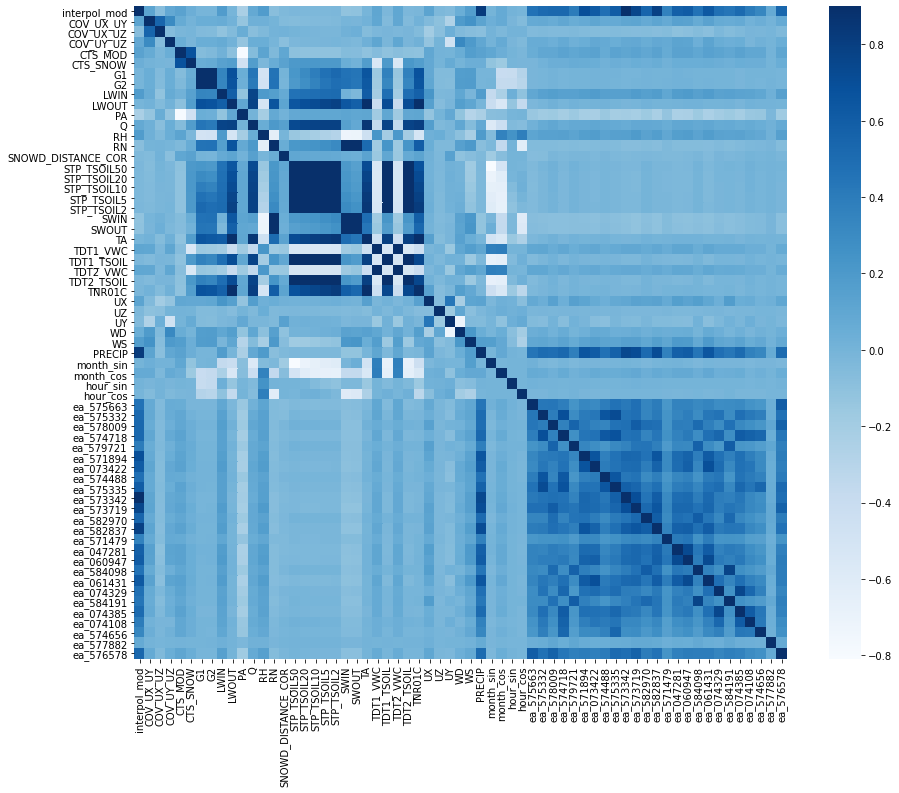

In [ ]:
corr = df.corr()
plt.subplots(figsize=(15,12))
sns.heatmap(corr, vmax=0.9, cmap="Blues", square=True)

In [ ]:
y = df['PRECIP']
df = df.drop(['PRECIP'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(df, y, test_size=0.2, random_state=42)

In [ ]:
total = df.isnull().sum().sort_values(ascending=False)
percent = 100*((df.isnull().sum()/ df.isnull().count())).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(5)

,Total,Percent
ea_575335,10835,13.871996
COV_UX_UZ,3168,4.055974
COV_UY_UZ,2242,2.870421
CTS_MOD,1992,2.550348
CTS_SNOW,870,1.113857


In [ ]:
#Plots the distribution of all features. Commented as takes a lot of time to run /can cause notebook to lag/crash notebook
"""f, ax = plt.subplots((len(df.columns)+1)//4,4,figsize=(20, 100)) #22
for n,feature in enumerate(df.columns):
  ax[n//4][n%4].set_title(feature)
  sns.distplot(df[feature], ax=ax[n//4][n%4])"""

'f, ax = plt.subplots((len(df.columns)+1)//4,4,figsize=(20, 100)) #22\nfor n,feature in enumerate(df.columns):\n  ax[n//4][n%4].set_title(feature)\n  sns.distplot(df[feature], ax=ax[n//4][n%4])'

In [ ]:
from scipy.stats import skew

featureSkewTestCols = list(df.columns.drop('DATE_TIME'))
skew_features = df[featureSkewTestCols].apply(lambda x: skew(x, nan_policy='omit', bias=False)).sort_values(ascending=False)
skew_features_DF = pd.DataFrame(skew_features, columns=['Skew'])
skew_features_DF.head(10)

,Skew
ea_577882,191.973544
ea_574656,77.482114
ea_571479,70.130178
ea_074108,22.285493
ea_582970,18.683141
ea_573342,15.831159
ea_579721,14.616256
ea_584191,14.491148
ea_584098,12.669432
ea_578009,11.424224


In [ ]:
def convertToClassification(dataSeries):
  newDataSeries = dataSeries.copy()
  for i in dataSeries.index:
    if dataSeries[i]>0:
      newDataSeries[i] = 1
    elif dataSeries[i] == 0:
      newDataSeries[i] = 0
    else:
      print("ERROR precip < 0 or NaN present")
  return newDataSeries

y_train_c = convertToClassification(y_train)
y_test_c = convertToClassification(y_test)

In [ ]:
X_train = X_train.sort_index(axis=0)
X_train_time = X_train.set_index('DATE_TIME')
y_train = y_train.sort_index(axis=0)
y_train_time = y_train.rename(X_train['DATE_TIME'])

In [ ]:
eaCols = [i for i in df.columns if i[0:2]=='ea']
TSOILCols = [i for i in df.columns if "TSOIL" in i]
interpolateCols = TSOILCols + ['PA']

In [ ]:
def interpolateEachSeries(missingData, colsToImpute):
  imputedData = pd.Series([])
  for i,col in enumerate(missingData.columns):
    seriesCol = missingData[col]
    if col in colsToImpute:
      imputedCol = seriesCol.interpolate(method='time', limit_direction='both', order=2, limit=2)
    else:
      imputedCol = seriesCol
    imputedData = pd.concat([imputedData, imputedCol], axis=1)
  imputedData = imputedData.drop(imputedData.columns[0], axis=1)
  print("Missing values interpolated:",(np.sum(np.isnan(X_train.drop('DATE_TIME',axis=1).to_numpy())))-(np.sum(np.isnan(imputedData.to_numpy()))))
  return imputedData

timeImputed = interpolateEachSeries(X_train.set_index('DATE_TIME'), interpolateCols)
X_train = timeImputed.set_index(X_train.index)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  


Missing values interpolated: 13


In [ ]:
y_train_c = y_train_c.sort_index(axis=0)

In [ ]:
X_test_time = X_test.set_index('DATE_TIME')
X_test = X_test.drop(['DATE_TIME'],axis=1)
y_test_c = y_test_c.reset_index()
y_test_c = y_test_c.drop("index", axis=1)

y_test = y_test.reset_index()
y_test = y_test.drop("index",axis=1)

### Feature Creation

In [ ]:
import datetime as dt
def minus_hours(time_string,hours):
  the_datetime = dt.datetime.strptime(time_string, '%Y-%m-%d %H:%M:%S')
  new_datetime = the_datetime + dt.timedelta(hours=-hours)
  return new_datetime.strftime('%Y-%m-%d %H:%M:%S')
minus_hours('2017-06-08 11:30:00',1)

'2017-06-08 10:30:00'

In [ ]:
def calculatePastRainfall(datetime_string, hours):
  """Returns the sum of rainfall in the past X hours.  Does NOT include the recorded rainfall at the current time. """
  datesToTry = pd.date_range(start=minus_hours(datetime_string,hours), end=minus_hours(datetime_string,0.5), freq='0.5H')
  validDates = [i for i in datesToTry if i in X_train_time.index]
  correspondingRainfall = [y_train_time[i] for i in validDates]
  rainfall = sum(correspondingRainfall)
  return rainfall
calculatePastRainfall('2017-06-08 11:30:00',24)

11.120000000000001

In [ ]:
def calculateAverageRainfall(datetime_string, hours):
  """Returns the sum of rainfall in the past X hours.  Does NOT include the recorded rainfall at the current time. """
  datesToTry = pd.date_range(start=minus_hours(datetime_string,hours), end=minus_hours(datetime_string,0.5), freq='0.5H')
  validDates = [i for i in datesToTry if i in X_train_time.index]
  correspondingRainfall = [y_train_time[i] for i in validDates]
  try:
    rainfall = sum(correspondingRainfall)/len(correspondingRainfall)
  except:
    rainfall = np.nan
  return rainfall
calculateAverageRainfall('2017-06-08 11:30:00',24)

0.30888888888888894

In [ ]:
def calculateAllRainfall(data, hours):
  """Returns series of all data that rainfall that occured in the past X hours."""
  pastRainfallList = []
  for i in data.index:
    pastRainfall = calculateAverageRainfall(str(i), hours)
    pastRainfallList.append(pastRainfall)
  pastRainfallSeries = pd.Series(data=pastRainfallList, index=X_train.index)
  return pastRainfallSeries
#past24hourrainfall = calculateAllRainfall(X_train_time,24)
#past12hourrainfall = calculateAllRainfall(X_train_time,12)
past6hourrainfall = calculateAllRainfall(X_train_time,6)
#past3hourrainfall = calculateAllRainfall(X_train_time,3)
#past2hourrainfall = calculateAllRainfall(X_train_time,2)
#past1hourrainfall = calculateAllRainfall(X_train_time,1)

In [ ]:
X_trainNew = X_train.copy()
X_trainNew["6Hr-Precip"] = past6hourrainfall

In [ ]:
def calculateAllRainfallTest(data, hours):
  """Returns series of all data that rainfall that occured in the past X hours. Only uses training data."""
  pastRainfallList = []
  for i in data.index:
    pastRainfall = calculateAverageRainfall(str(i), hours)
    pastRainfallList.append(pastRainfall)
  pastRainfallSeries = pd.Series(data=pastRainfallList, index=X_test.index)
  return pastRainfallSeries

#past24hourrainfallTest = calculateAllRainfallTest(X_test_time,24)
#past12hourrainfallTest = calculateAllRainfallTest(X_test_time,12)
past6hourrainfallTest = calculateAllRainfallTest(X_test_time,6)
#past3hourrainfallTest = calculateAllRainfallTest(X_test_time,3)
#past2hourrainfallTest = calculateAllRainfallTest(X_test_time,2)
#past1hourrainfallTest = calculateAllRainfallTest(X_test_time,1)

In [ ]:
X_testNew = X_test.copy()

X_testNew["6Hr-Precip"] = past6hourrainfallTest


In [ ]:
print("Number NANs in 6-Hour Precip Column (Train):", np.sum(np.isnan(X_trainNew["6Hr-Precip"].to_numpy())))
print("Number NANs in 6-Hour Precip Column (Test):", np.sum(np.isnan(X_testNew["6Hr-Precip"].to_numpy())))

Number NANs in 6-Hour Precip Column (Train): 10
Number NANs in 6-Hour Precip Column (Test): 1


### Test Data Imputation

In [ ]:
from sklearn.experimental import enable_iterative_imputer  # noqa
from sklearn.impute import IterativeImputer
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.neighbors import KNeighborsClassifier

In [ ]:
impute_estimator =   ExtraTreesRegressor(n_estimators=1, random_state=0)
missForest = IterativeImputer(random_state=0, estimator=impute_estimator).fit(X_trainNew) #Fit on the training data only
X_test_missF = missForest.transform(X_testNew) #transform the test data only
X_test_missF_DF = pd.DataFrame(data = X_test_missF, columns=X_testNew.columns)

/usr/local/lib/python3.6/dist-packages/sklearn/impute/_iterative.py:638: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)


### Training Data Imputation/Deletion

When preparing the training data we have three main options. 
1. We can impute the missing data, which will introduce bias.
2. We can delete rows with missing data, which removes a lot of useful information.
3. We can do nothing and only use machine learning algorithms that can handle missingness, which potentially will not perform as well.

We make a copy of the full training data with nans still present so that machine learning algorithms that can handle missingness has the option to use this data, as opposed to the data with multiple rows removed.

In [ ]:
X_train_nan = X_trainNew.copy()
y_train_nan = y_train.copy()
y_train_c_nan = y_train_c.copy()

#We may remove columns from the non-missing training data hence we make a copy of the test data as well, so we can use it with the other algorithms.
#Also there are problems when transforming features with NANs present. Therefore we make a copy of the test data before it is transformed for if it's decided that using the 
#Training data with missing values is the best option. 
X_test_original = X_test_missF_DF.copy()

In [ ]:
#Drop all precipitation data with 0 precipitation
y_train_reg_nan = y_train_nan.copy()
for i in y_train_reg_nan.index:
  if y_train_reg_nan[i] <= 0:
    y_train_reg_nan.drop(i, inplace=True)
y_train_reg_nan.head()

1726    0.070
1866    0.050
1867    0.119
1868    0.001
1873    0.839
Name: PRECIP, dtype: float64

In [ ]:
X_train_reg_nan = X_train_nan.copy() #X_train_reg = X_train.copy()
for i in X_train_reg_nan.index:
  if i not in y_train_reg_nan.index:
    X_train_reg_nan.drop(i, inplace=True)
X_train_reg_nan.head()

,interpol_mod,COV_UX_UY,COV_UX_UZ,COV_UY_UZ,CTS_MOD,CTS_SNOW,G1,G2,LWIN,LWOUT,PA,Q,RH,RN,SNOWD_DISTANCE_COR,STP_TSOIL50,STP_TSOIL20,STP_TSOIL10,STP_TSOIL5,STP_TSOIL2,SWIN,SWOUT,TA,TDT1_VWC,TDT1_TSOIL,TDT2_VWC,TDT2_TSOIL,TNR01C,UX,UZ,UY,WD,WS,month_sin,month_cos,hour_sin,hour_cos,ea_575663,ea_575332,ea_578009,ea_574718,ea_579721,ea_571894,ea_073422,ea_574488,ea_575335,ea_573342,ea_573719,ea_582970,ea_582837,ea_571479,ea_047281,ea_060947,ea_584098,ea_061431,ea_074329,ea_584191,ea_074385,ea_074108,ea_574656,ea_577882,ea_576578,6Hr-Precip
1726,0.109,0.041,0.011,-0.024,734.0,357.0,7.47553,12.82135,381.4,394.9,986.0,11.05,89.8,65.610,0.050,13.00,13.94,14.37,14.87,15.33,94.60,15.490,14.35,31.78,14.21,35.43,14.30,14.77,-0.111,-0.046,0.568,78.94247,0.64415,-1.0,-0.0,0.259,-0.966,0.0,0.0,0.2,0.0,0.0,0.0,0.0,0.0,0.0,0.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.2,0.0,0.000000
1866,0.000,0.052,-0.015,0.012,667.0,338.0,-0.92074,-4.53416,372.9,376.4,987.0,10.54,99.9,48.910,0.039,12.38,11.48,10.58,10.49,10.81,61.82,9.410,11.86,30.57,11.19,35.71,11.33,12.11,0.217,-0.042,-0.155,215.53768,0.64630,-1.0,-0.0,0.707,-0.707,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
1867,0.000,0.067,-0.013,0.040,718.0,352.0,0.67932,-0.98955,374.0,378.5,987.0,10.72,99.8,50.040,0.043,12.36,11.47,10.68,10.72,11.17,63.93,9.390,12.14,30.57,11.28,35.71,11.37,12.46,0.453,-0.049,0.023,177.09344,0.82733,-1.0,-0.0,0.707,-0.707,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.007143
1868,0.000,0.106,-0.080,0.033,734.0,334.0,2.13804,2.36363,375.0,380.8,986.0,10.78,99.4,108.930,0.040,12.35,11.46,10.80,10.96,11.50,135.30,20.570,12.30,30.46,11.35,35.54,11.44,12.68,0.704,-0.055,0.101,171.83572,0.88008,-1.0,-0.0,0.500,-0.866,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.021125
1873,1.342,0.053,-0.041,0.021,716.0,295.0,10.65934,21.30127,379.3,382.0,986.0,10.65,94.4,32.731,0.038,12.32,11.56,11.60,12.45,13.12,40.17,4.739,12.93,30.46,11.80,35.76,11.75,13.00,-0.134,-0.087,-0.576,283.09628,0.95078,-1.0,-0.0,0.000,-1.000,0.0,0.2,0.0,0.0,0.2,0.6,0.6,0.0,0.0,2.2,1.4,0.2,0.2,0.0,0.0,0.0,0.4,0.0,0.0,0.2,0.0,0.0,0.0,0.0,0.0,0.017000


In [ ]:
y_train_reg_nan_log = np.log1p(y_train_reg_nan)

Deleting rows that contain missing values.

We first need to remove columns with high missingness so we minimise the amount of data lost by dropping rows that containing missing values.

The best way to do this is to consider both the percentage of missingness and the importance of the variable. For example interpol_mod often has relatively high missingness but is also a very important feature, whereas TSoil is often not as important (and often has many similar sensors) so this column can be removed even if there is very little missingness.

In [ ]:
XGBtestc = XGBClassifier(learning_rate=0.05, n_estimators=250, reg_lambda=0.6, max_depth=3, gamma=0.15, subsample=1, min_child_weight=1)

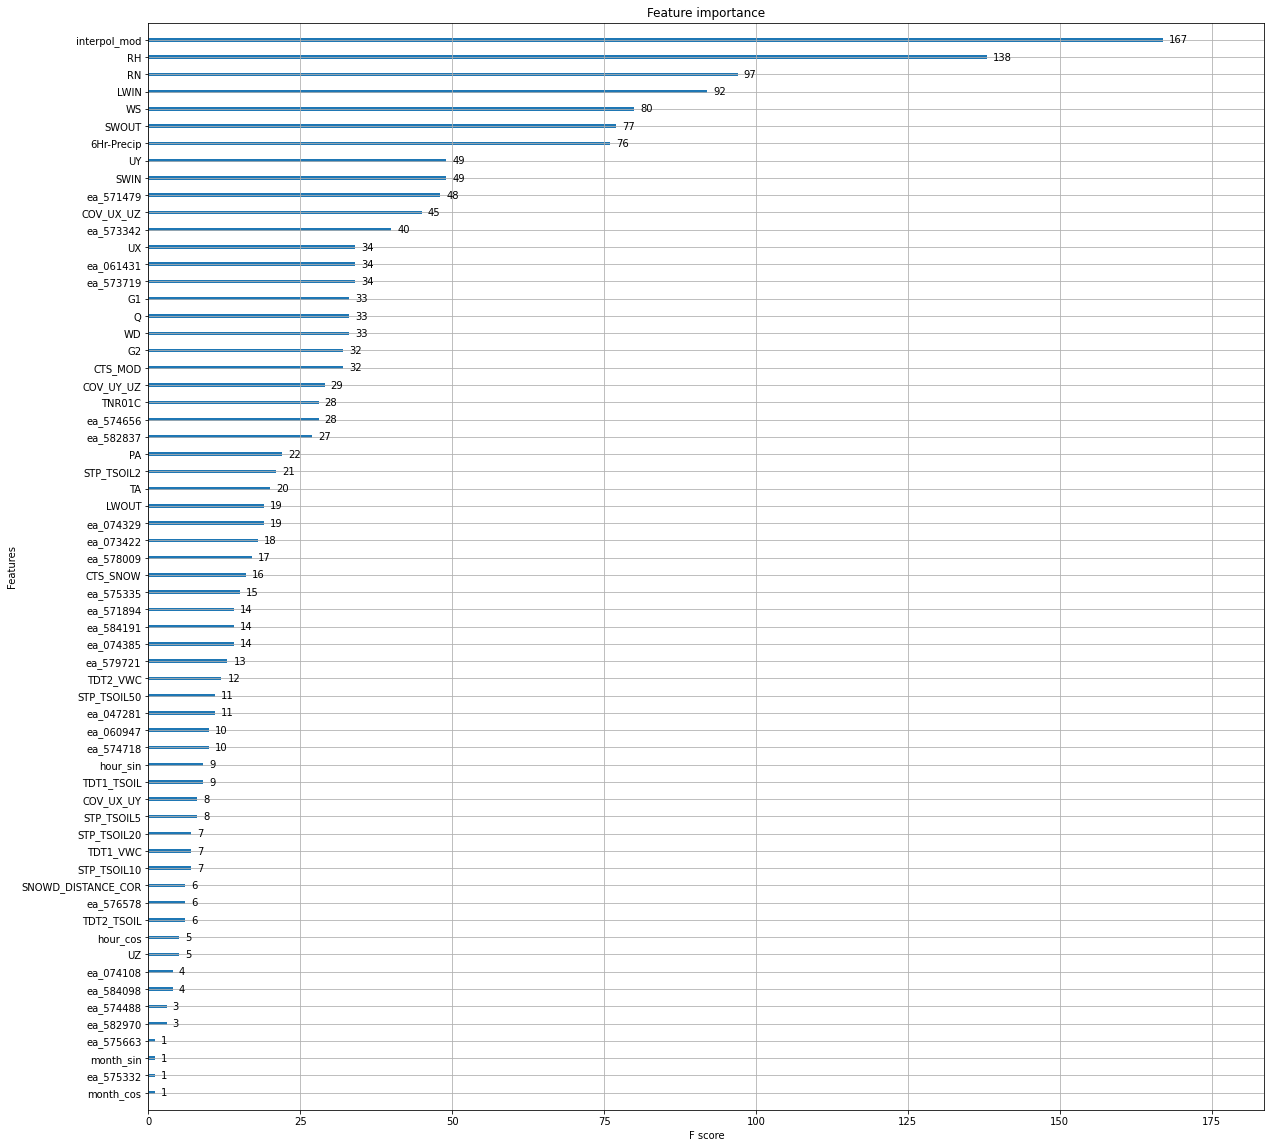

In [ ]:
XGBtestc.fit(X_train_nan, y_train_c_nan)
from xgboost import plot_importance
f, axXGBOOST = plt.subplots(figsize=(20, 20)) #22
plotimportanceC = plot_importance(XGBtestc,ax=axXGBOOST)
plt.show()

In [ ]:
XGBtestr = XGBRegressor(learning_rate=0.05, n_estimators=3460, max_depth=6, min_child_weight=0, gamma=0.4, subsample=0.7, colsample_bytree=0.7, objective='reg:squarederror', nthread=-1, scale_pos_weight=1, seed=27, reg_alpha=0.00006, random_state=0)

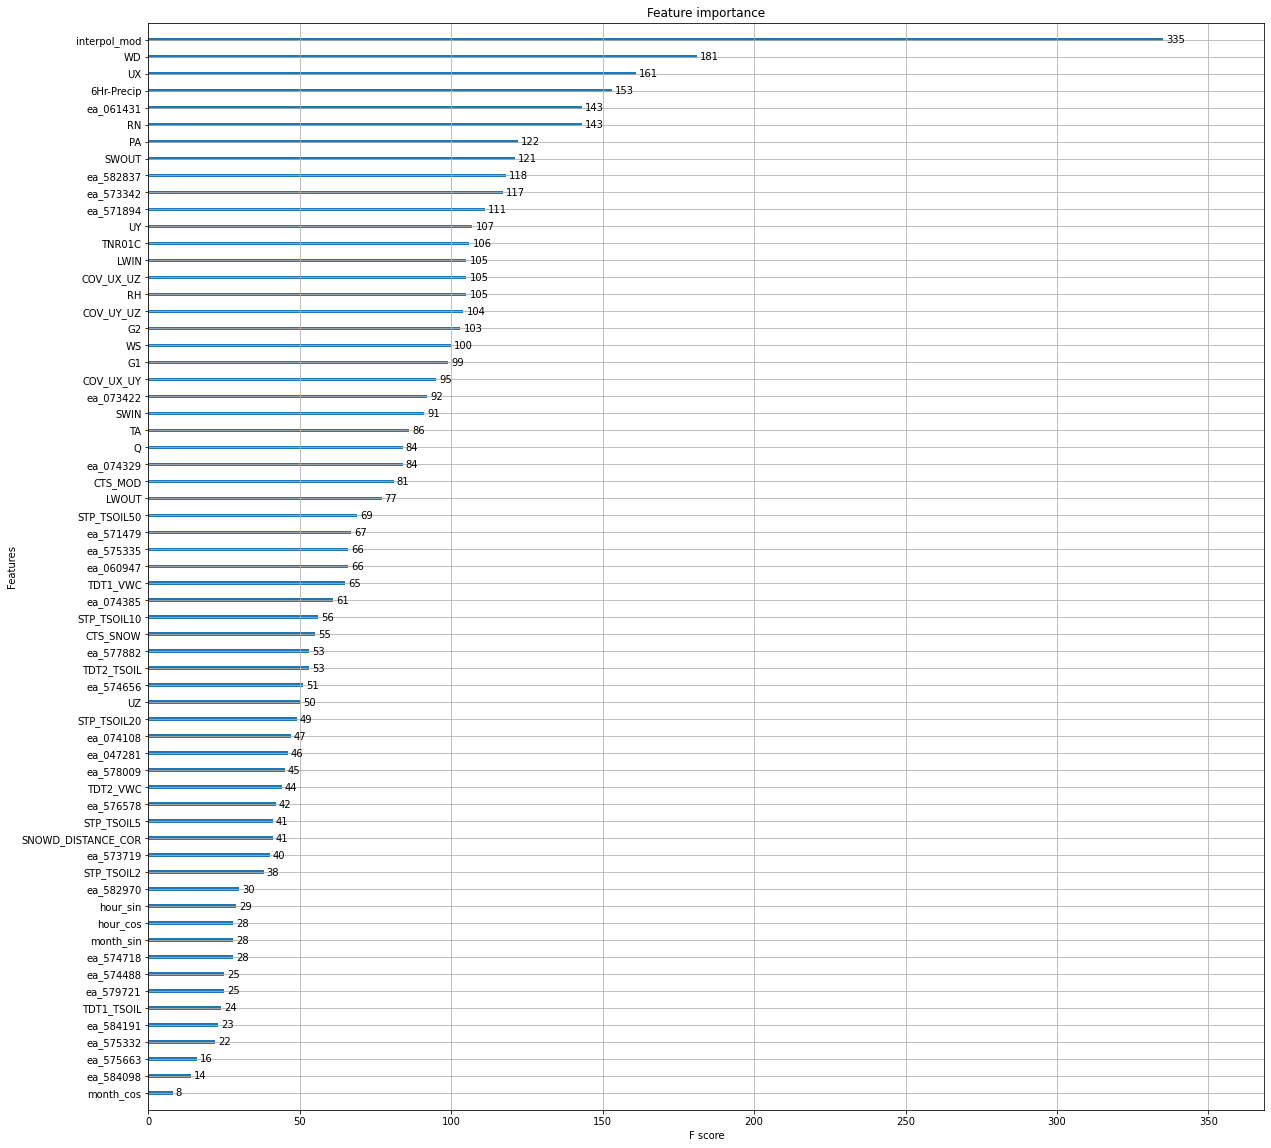

In [ ]:
XGBtestr.fit(X_train_reg_nan, y_train_reg_nan_log)
f, axXGBOOST = plt.subplots(figsize=(20, 20))
plotimportantceR = plot_importance(XGBtestr,ax=axXGBOOST)
plt.show()

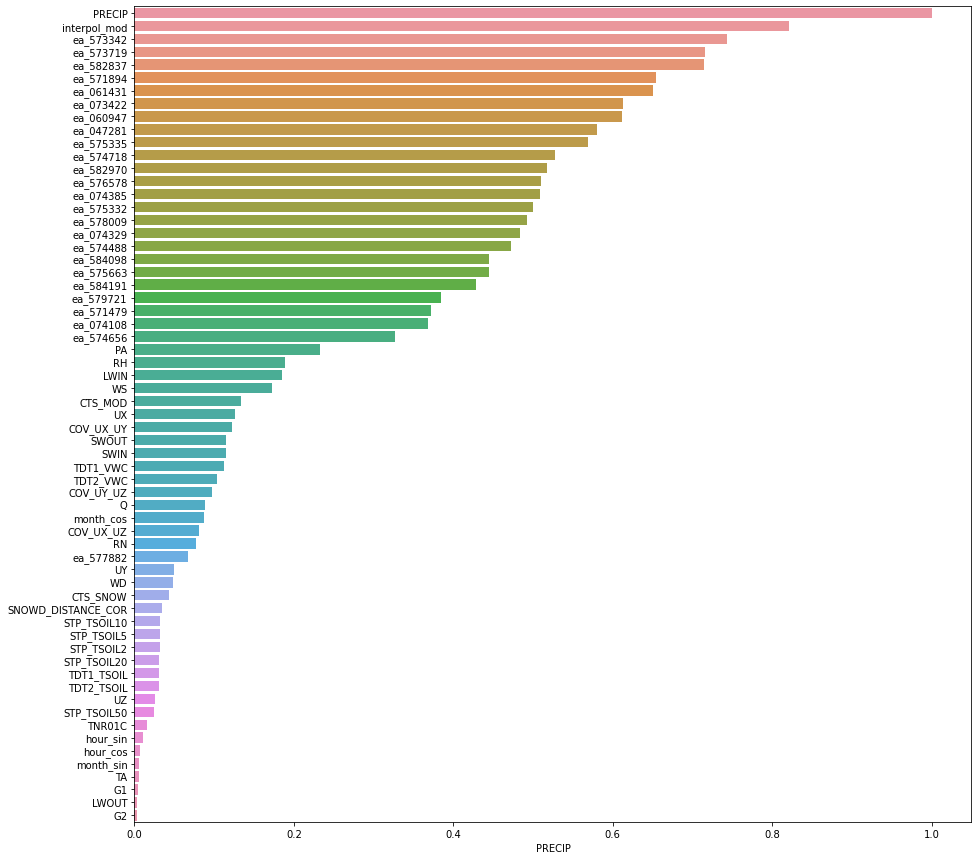

In [ ]:
precipCorrelations = corr['PRECIP']
precipCorrelations = precipCorrelations.transform(lambda x:abs(x)).sort_values(ascending=False)
plt.subplots(figsize=(15,15))
sns.barplot(y=precipCorrelations.index,x=precipCorrelations)

In [ ]:
X_train_reg_nan.head()

,interpol_mod,COV_UX_UY,COV_UX_UZ,COV_UY_UZ,CTS_MOD,CTS_SNOW,G1,G2,LWIN,LWOUT,PA,Q,RH,RN,SNOWD_DISTANCE_COR,STP_TSOIL50,STP_TSOIL20,STP_TSOIL10,STP_TSOIL5,STP_TSOIL2,SWIN,SWOUT,TA,TDT1_VWC,TDT1_TSOIL,TDT2_VWC,TDT2_TSOIL,TNR01C,UX,UZ,UY,WD,WS,month_sin,month_cos,hour_sin,hour_cos,ea_575663,ea_575332,ea_578009,ea_574718,ea_579721,ea_571894,ea_073422,ea_574488,ea_575335,ea_573342,ea_573719,ea_582970,ea_582837,ea_571479,ea_047281,ea_060947,ea_584098,ea_061431,ea_074329,ea_584191,ea_074385,ea_074108,ea_574656,ea_577882,ea_576578,6Hr-Precip
1726,0.109,0.041,0.011,-0.024,734.0,357.0,7.47553,12.82135,381.4,394.9,986.0,11.05,89.8,65.610,0.050,13.00,13.94,14.37,14.87,15.33,94.60,15.490,14.35,31.78,14.21,35.43,14.30,14.77,-0.111,-0.046,0.568,78.94247,0.64415,-1.0,-0.0,0.259,-0.966,0.0,0.0,0.2,0.0,0.0,0.0,0.0,0.0,0.0,0.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.2,0.0,0.000000
1866,0.000,0.052,-0.015,0.012,667.0,338.0,-0.92074,-4.53416,372.9,376.4,987.0,10.54,99.9,48.910,0.039,12.38,11.48,10.58,10.49,10.81,61.82,9.410,11.86,30.57,11.19,35.71,11.33,12.11,0.217,-0.042,-0.155,215.53768,0.64630,-1.0,-0.0,0.707,-0.707,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
1867,0.000,0.067,-0.013,0.040,718.0,352.0,0.67932,-0.98955,374.0,378.5,987.0,10.72,99.8,50.040,0.043,12.36,11.47,10.68,10.72,11.17,63.93,9.390,12.14,30.57,11.28,35.71,11.37,12.46,0.453,-0.049,0.023,177.09344,0.82733,-1.0,-0.0,0.707,-0.707,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.007143
1868,0.000,0.106,-0.080,0.033,734.0,334.0,2.13804,2.36363,375.0,380.8,986.0,10.78,99.4,108.930,0.040,12.35,11.46,10.80,10.96,11.50,135.30,20.570,12.30,30.46,11.35,35.54,11.44,12.68,0.704,-0.055,0.101,171.83572,0.88008,-1.0,-0.0,0.500,-0.866,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.021125
1873,1.342,0.053,-0.041,0.021,716.0,295.0,10.65934,21.30127,379.3,382.0,986.0,10.65,94.4,32.731,0.038,12.32,11.56,11.60,12.45,13.12,40.17,4.739,12.93,30.46,11.80,35.76,11.75,13.00,-0.134,-0.087,-0.576,283.09628,0.95078,-1.0,-0.0,0.000,-1.000,0.0,0.2,0.0,0.0,0.2,0.6,0.6,0.0,0.0,2.2,1.4,0.2,0.2,0.0,0.0,0.0,0.4,0.0,0.0,0.2,0.0,0.0,0.0,0.0,0.0,0.017000


In [ ]:
bestCols = ['interpol_mod', 'WS', 'RH', '6Hr-Precip', 'RN', 'UY', 'WD', 'PA'] 
goodCols = eaCols + ['COV_UX_UY', 'COV_TS_UY', 'COV_TS_UX','COV_UX_UZ', 'COV_UY_UZ', 'G2', 'LWIN'] + bestCols

In [ ]:
print("Dropping Columns:")
dropCols = []
for col in missing_data.index:
  if missing_data.loc[col].Percent>30 and col !='interpol_mod':
    dropCols.append(col)
  elif missing_data.loc[col].Percent>15 and col not in bestCols:
    dropCols.append(col)
  elif missing_data.loc[col].Percent>5 and col not in goodCols:
    dropCols.append(col)

print(dropCols)

Dropping Columns:
[]


In [ ]:
X_trainNew.columns

Index(['interpol_mod', 'COV_UX_UY', 'COV_UX_UZ', 'COV_UY_UZ', 'CTS_MOD',
       'CTS_SNOW', 'G1', 'G2', 'LWIN', 'LWOUT', 'PA', 'Q', 'RH', 'RN',
       'SNOWD_DISTANCE_COR', 'STP_TSOIL50', 'STP_TSOIL20', 'STP_TSOIL10',
       'STP_TSOIL5', 'STP_TSOIL2', 'SWIN', 'SWOUT', 'TA', 'TDT1_VWC',
       'TDT1_TSOIL', 'TDT2_VWC', 'TDT2_TSOIL', 'TNR01C', 'UX', 'UZ', 'UY',
       'WD', 'WS', 'month_sin', 'month_cos', 'hour_sin', 'hour_cos',
       'ea_575663', 'ea_575332', 'ea_578009', 'ea_574718', 'ea_579721',
       'ea_571894', 'ea_073422', 'ea_574488', 'ea_575335', 'ea_573342',
       'ea_573719', 'ea_582970', 'ea_582837', 'ea_571479', 'ea_047281',
       'ea_060947', 'ea_584098', 'ea_061431', 'ea_074329', 'ea_584191',
       'ea_074385', 'ea_074108', 'ea_574656', 'ea_577882', 'ea_576578',
       '6Hr-Precip'],
      dtype='object')

In [ ]:
X_trainNew.drop(dropCols, inplace= True, axis=1)
X_test_missF_DF.drop(dropCols, inplace = True, axis=1)

In [ ]:
X_trainNew.columns

Index(['interpol_mod', 'COV_UX_UY', 'COV_UX_UZ', 'COV_UY_UZ', 'CTS_MOD',
       'CTS_SNOW', 'G1', 'G2', 'LWIN', 'LWOUT', 'PA', 'Q', 'RH', 'RN',
       'SNOWD_DISTANCE_COR', 'STP_TSOIL50', 'STP_TSOIL20', 'STP_TSOIL10',
       'STP_TSOIL5', 'STP_TSOIL2', 'SWIN', 'SWOUT', 'TA', 'TDT1_VWC',
       'TDT1_TSOIL', 'TDT2_VWC', 'TDT2_TSOIL', 'TNR01C', 'UX', 'UZ', 'UY',
       'WD', 'WS', 'month_sin', 'month_cos', 'hour_sin', 'hour_cos',
       'ea_575663', 'ea_575332', 'ea_578009', 'ea_574718', 'ea_579721',
       'ea_571894', 'ea_073422', 'ea_574488', 'ea_575335', 'ea_573342',
       'ea_573719', 'ea_582970', 'ea_582837', 'ea_571479', 'ea_047281',
       'ea_060947', 'ea_584098', 'ea_061431', 'ea_074329', 'ea_584191',
       'ea_074385', 'ea_074108', 'ea_574656', 'ea_577882', 'ea_576578',
       '6Hr-Precip'],
      dtype='object')

In [ ]:
print(len(X_trainNew))
X_train2 = X_trainNew.dropna()
print(len(X_train2))

62485
47764


In [ ]:
def removeUneccessaryPrecip(Xdf, ySeries):
  """Deletes precipitation target values if there is no matching index in the test data """
  newYSeries = ySeries.copy()
  for i in newYSeries.index:
    if i not in Xdf.index:
      newYSeries.drop(i, inplace=True)
  return newYSeries

y_train_c = removeUneccessaryPrecip(X_train2, y_train_c)
y_train = removeUneccessaryPrecip(X_train2, y_train)

### Transforming Features

We transform highly skewed features.

In [ ]:
skew_features.drop(dropCols, inplace= True)

In [ ]:
from scipy.special import boxcox1p
from scipy.stats import boxcox
from scipy.stats import boxcox_normmax

X_train2 = X_train2.copy()
X_test2 = X_test_missF_DF.copy()
badTransforms = ['PRECIP','COV_UY_UZ', 'COV_TS_UX', 'COV_TS_UY', 'COV_TS_UZ', 'COV_UX_UY', 'COV_UX_UZ', 'COV_UY_UZ', 'interpol_mod', 'month_sin', 'month_cos', 'hour_cos', 'hour_sin', 'HS', 'CTS_MOD_RH', 'UZ']
eaTransforms = [i for i in skew_features.index if i[0:2]=='ea']
TDTdata = [i for i in skew_features.index if i[0:3]=='TDT']
print(TDTdata)
print(eaTransforms)
print("Features being made positive: \n")
for i in skew_features.index:
  #We cannot take a logarithm/boxcox of negative numbers, so we make them positive by adding a constant (this changes mean but not variance)
  if abs(skew_features[i])>0.8 and (i not in badTransforms) and (i not in eaTransforms) and (min(X_train2[i])<=0 or min(X_test2[i]<=0)):
    print(i)
    minVal = min(min(X_train2[i]),min(X_test2[i])) # Could just change this to a different constant
    X_train2[i] = X_train2[i] - (minVal-1) # Ensure the exact transform is done to both train and test data
    X_test2[i] = X_test2[i] - (minVal-1)

print("---")
print("Features being transformed to reduce skew: \n")
for i in skew_features.index:
  if abs(skew_features[i])>0.8 and (i not in badTransforms) and (i not in eaTransforms):
    print(i)
    X_test2[i] = boxcox(X_test2[i], boxcox_normmax(X_train2[i])) #Make sure to transform test data first
    X_train2[i] = boxcox(X_train2[i], boxcox_normmax(X_train2[i]))
    #X_train2[i] = np.log1p(X_train2) 
    #X_test2[i] = np.log1p(X_test2) 
skew_features2 = X_train2.apply(lambda x: skew(x, nan_policy='omit')).sort_values(ascending=False)
skew_features_DF2 = pd.DataFrame(skew_features2, columns=['Skew'])
skew_features_DF2.head(20)

['TDT1_TSOIL', 'TDT2_TSOIL', 'TDT1_VWC', 'TDT2_VWC']
['ea_577882', 'ea_574656', 'ea_571479', 'ea_074108', 'ea_582970', 'ea_573342', 'ea_579721', 'ea_584191', 'ea_584098', 'ea_578009', 'ea_575663', 'ea_074385', 'ea_073422', 'ea_074329', 'ea_576578', 'ea_575332', 'ea_574488', 'ea_575335', 'ea_574718', 'ea_571894', 'ea_060947', 'ea_047281', 'ea_582837', 'ea_061431', 'ea_573719']
Features being made positive: 

SWOUT
SWIN
RN
G1
G2
UX
---
Features being transformed to reduce skew: 

SWOUT
SWIN
RN
G1
G2
WS
UX
CTS_SNOW


/usr/local/lib/python3.6/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


TDT1_VWC
TDT2_VWC
RH


,Skew
ea_577882,210.593603
ea_571479,68.356814
COV_UX_UZ,26.423013
ea_074108,24.997276
ea_579721,15.401155
ea_574656,14.936777
ea_584098,14.434180
COV_UX_UY,14.165416
ea_584191,13.826003
ea_074385,11.155122


## Classification

In [ ]:
from imblearn.pipeline import make_pipeline as imbalanced_make_pipeline #Don't get confused with sklearn's
from imblearn.combine import SMOTEENN
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [ ]:
kf = KFold(n_splits=5, random_state=42, shuffle=True)

In [ ]:
XGB = XGBClassifier(learning_rate=0.05, n_estimators=250, reg_lambda=0.6, max_depth=3, gamma=0.15, subsample=1, min_child_weight=1)
XGB2 = XGBClassifier(learning_rate=0.05, n_estimators=250, reg_lambda=0.6, max_depth=3, gamma=0.15, subsample=1, min_child_weight=1) # This is done so it can be used in the pipeline and not in the pipeline (parameter tuning reasons)

In [ ]:
RFC = RandomForestClassifier(n_estimators = 300, criterion='entropy', max_depth= None, min_samples_split=2, min_samples_leaf=1, n_jobs=-1)

In [ ]:
KNN = KNeighborsClassifier(algorithm='auto', leaf_size=26, metric='minkowski', 
                           metric_params=None, n_jobs=-1, n_neighbors=5, p=2, 
                           weights='uniform')

In [ ]:
svc = SVC(C=1, kernel='rbf', degree=5, gamma='scale')

In [ ]:
 XGB_pipeline = imbalanced_make_pipeline(SMOTEENN(random_state=0, sampling_strategy=0.80), XGB2) #We make sure we do SMOTE during cross validation, note before

In [ ]:
 RFC_pipeline = imbalanced_make_pipeline(SMOTEENN(random_state=0, sampling_strategy=0.80), RFC) #We make sure we do SMOTE during cross validation, note before

In [ ]:
svc_pipeline = imbalanced_make_pipeline(StandardScaler(), SMOTEENN(random_state=0, sampling_strategy=0.80), svc)

In [ ]:
KNN_pipeline = imbalanced_make_pipeline(StandardScaler(), SMOTEENN(random_state=0, sampling_strategy=0.80), KNN)

### Parameter Tuning - Grid Search

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

In [ ]:
RFC_pipeline.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'smoteenn', 'randomforestclassifier', 'smoteenn__enn', 'smoteenn__random_state', 'smoteenn__ratio', 'smoteenn__sampling_strategy', 'smoteenn__smote', 'randomforestclassifier__bootstrap', 'randomforestclassifier__ccp_alpha', 'randomforestclassifier__class_weight', 'randomforestclassifier__criterion', 'randomforestclassifier__max_depth', 'randomforestclassifier__max_features', 'randomforestclassifier__max_leaf_nodes', 'randomforestclassifier__max_samples', 'randomforestclassifier__min_impurity_decrease', 'randomforestclassifier__min_impurity_split', 'randomforestclassifier__min_samples_leaf', 'randomforestclassifier__min_samples_split', 'randomforestclassifier__min_weight_fraction_leaf', 'randomforestclassifier__n_estimators', 'randomforestclassifier__n_jobs', 'randomforestclassifier__oob_score', 'randomforestclassifier__random_state', 'randomforestclassifier__verbose', 'randomforestclassifier__warm_start'])

In [ ]:
RFC_param_grid = {
    'randomforestclassifier__n_estimators':[100,300],
    'randomforestclassifier__criterion':['entropy','gini'],
    'randomforestclassifier__max_depth':[None],
    'randomforestclassifier__min_samples_split':[2],
    'randomforestclassifier__min_samples_leaf':[1]
}
grid_rfc = GridSearchCV(RFC_pipeline, RFC_param_grid, scoring='roc_auc')
grid_rfc.fit(X_train2.to_numpy(), y_train_c)
rfc_best_params = grid_rfc.best_params_

RFC_pipeline.set_params(**rfc_best_params)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarni

KeyboardInterrupt: ignored

In [ ]:
svc_pipeline.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'standardscaler', 'smoteenn', 'svc', 'standardscaler__copy', 'standardscaler__with_mean', 'standardscaler__with_std', 'smoteenn__enn', 'smoteenn__random_state', 'smoteenn__ratio', 'smoteenn__sampling_strategy', 'smoteenn__smote', 'svc__C', 'svc__break_ties', 'svc__cache_size', 'svc__class_weight', 'svc__coef0', 'svc__decision_function_shape', 'svc__degree', 'svc__gamma', 'svc__kernel', 'svc__max_iter', 'svc__probability', 'svc__random_state', 'svc__shrinking', 'svc__tol', 'svc__verbose'])

In [ ]:
SVC_param_grid = {
    'svc__C':[1,2,3],
    'svc__degree':[5],
    'svc__gamma':['scale'],
    'svc__kernel':['rbf']
}
grid_svc = GridSearchCV(svc_pipeline, SVC_param_grid, scoring='roc_auc')
grid_svc.fit(X_train2.to_numpy(), y_train_c)
svc_best_params = grid_svc.best_params_

svc_pipeline.set_params(**svc_best_params)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarni

Pipeline(memory=None,
         steps=[('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('smoteenn',
                 SMOTEENN(enn=None, random_state=0, ratio=None,
                          sampling_strategy=0.8, smote=None)),
                ('svc',
                 SVC(C=1, break_ties=False, cache_size=200, class_weight=None,
                     coef0=0.0, decision_function_shape='ovr', degree=5,
                     gamma='scale', kernel='rbf', max_iter=-1,
                     probability=False, random_state=None, shrinking=True,
                     tol=0.001, verbose=False))],
         verbose=False)

In [ ]:
KNN_pipeline.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'standardscaler', 'smoteenn', 'kneighborsclassifier', 'standardscaler__copy', 'standardscaler__with_mean', 'standardscaler__with_std', 'smoteenn__enn', 'smoteenn__random_state', 'smoteenn__ratio', 'smoteenn__sampling_strategy', 'smoteenn__smote', 'kneighborsclassifier__algorithm', 'kneighborsclassifier__leaf_size', 'kneighborsclassifier__metric', 'kneighborsclassifier__metric_params', 'kneighborsclassifier__n_jobs', 'kneighborsclassifier__n_neighbors', 'kneighborsclassifier__p', 'kneighborsclassifier__weights'])

In [ ]:
KNN_param_grid = {
    'kneighborsclassifier__n_neighbors':[5,7,9],
    'kneighborsclassifier__weights':['distance']
}
grid_knn = GridSearchCV(KNN_pipeline, KNN_param_grid, scoring='roc_auc')
grid_knn.fit(X_train2.to_numpy(), y_train_c)
knn_best_params = grid_knn.best_params_

KNN_pipeline.set_params(**knn_best_params)

In [ ]:
XGB_pipeline.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'smoteenn', 'xgbclassifier', 'smoteenn__enn', 'smoteenn__random_state', 'smoteenn__ratio', 'smoteenn__sampling_strategy', 'smoteenn__smote', 'xgbclassifier__base_score', 'xgbclassifier__booster', 'xgbclassifier__colsample_bylevel', 'xgbclassifier__colsample_bynode', 'xgbclassifier__colsample_bytree', 'xgbclassifier__gamma', 'xgbclassifier__learning_rate', 'xgbclassifier__max_delta_step', 'xgbclassifier__max_depth', 'xgbclassifier__min_child_weight', 'xgbclassifier__missing', 'xgbclassifier__n_estimators', 'xgbclassifier__n_jobs', 'xgbclassifier__nthread', 'xgbclassifier__objective', 'xgbclassifier__random_state', 'xgbclassifier__reg_alpha', 'xgbclassifier__reg_lambda', 'xgbclassifier__scale_pos_weight', 'xgbclassifier__seed', 'xgbclassifier__silent', 'xgbclassifier__subsample', 'xgbclassifier__verbosity'])

In [ ]:
xgboost_param_grid = {'xgbclassifier__learning_rate':[0.03,0.05,0.07],
                  'xgbclassifier__n_estimators': [200],#The higher the better 
                  'xgbclassifier__max_depth':[3,4],
                  'xgbclassifier__gamma': [0.15],
                  'xgbclassifier__reg_lambda': [0.6]
              }
grid_xgb = GridSearchCV(XGB_pipeline, xgboost_param_grid, scoring='roc_auc')
grid_xgb.fit(X_train2.to_numpy(), y_train_c)
xgb_best_Params = grid_xgb.best_params_


XGB_pipeline.set_params(**xgb_best_Params)

XGB version with nan still present:

In [ ]:
xgboost_param_grid_nan = {'learning_rate':[0.02,0.03,0.05],
                  'n_estimators': [250],#The higher the better 
                  'max_depth':[3,4],
                  'gamma': [0.15],
                  'reg_lambda': [0.6]
              }
grid_xgb_nan = GridSearchCV(XGB, xgboost_param_grid_nan, scoring='roc_auc')
grid_xgb_nan.fit(X_train_nan, y_train_c_nan)
xgb_nan_best_Params = grid_xgb_nan.best_params_

XGB.set_params(**xgb_nan_best_Params)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0.15,
              learning_rate=0.03, max_delta_step=0, max_depth=4,
              min_child_weight=1, missing=None, n_estimators=250, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=0.6, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

### Classification - Cross validation

In [ ]:
mean_roc_scores = []
classification_estimators = []

In [ ]:
SVC_scores = cross_val_score(svc_pipeline, X_train2.to_numpy(), y_train_c, cv=kf,scoring="roc_auc")
print("Mean Score", SVC_scores.mean(), "SD:", SVC_scores.std())
mean_roc_scores.append(SVC_scores.mean())
classification_estimators.append(svc_pipeline)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarni

KeyboardInterrupt: ignored

In [ ]:
KNN_scores = cross_val_score(KNN_pipeline, X_train2.to_numpy(), y_train_c, cv=kf,scoring="roc_auc")
print("Mean Score", KNN_scores.mean(), "SD:", KNN_scores.std())
mean_roc_scores.append(KNN_scores.mean())
classification_estimators.append(KNN_pipeline)

In [ ]:
RFC_scores = cross_val_score(RFC_pipeline, X_train2.to_numpy(), y_train_c, cv=kf,scoring="roc_auc")
print("Mean Score", RFC_scores.mean(), "SD:", RFC_scores.std())
mean_roc_scores.append(RFC_scores.mean())
classification_estimators.append(RFC_pipeline)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarni

Mean Score 0.9698225931521482 SD: 0.0016381440705597375


In [ ]:
XGB_scores = cross_val_score(XGB_pipeline, X_train2.to_numpy(), y_train_c, cv=kf,scoring="roc_auc")
print("Mean Score", XGB_scores.mean(), "SD:", XGB_scores.std())
mean_roc_scores.append(XGB_scores.mean())
classification_estimators.append(XGB_pipeline)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarni

Mean Score 0.9629861342441393 SD: 0.0039087821308658914


XGBoost can handle missing values, hence we also try classification with missing data still present.

In [ ]:
XGB_nan_scores = cross_val_score(XGB, X_train_nan, y_train_c_nan, cv=kf,scoring="roc_auc") #"f1_weighted"
print("Mean Score", XGB_nan_scores.mean(), "SD:", XGB_nan_scores.std())
mean_roc_scores.append(XGB_nan_scores.mean() + 0.01) #Scores are slightly different as this uses different dataset
classification_estimators.append(XGB)



Mean Score 0.9718969897677608 SD: 0.0013998129518903663


In [ ]:
best_value = max(mean_roc_scores)
print(best_value)
best_index = mean_roc_scores.index(best_value)
bestModel = classification_estimators[best_index]
print(bestModel)

0.9818969897677609
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0.15,
              learning_rate=0.03, max_delta_step=0, max_depth=4,
              min_child_weight=1, missing=None, n_estimators=250, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=0.6, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)


In [ ]:
#temporary
#bestModel = XGB

## Regression

### Regression Preprocessing

In [ ]:
#Drop all precipitation data with 0 precipitation
y_train_reg = y_train.copy()
for i in y_train_reg.index:
  if y_train_reg[i] <= 0:
    y_train_reg.drop(i, inplace=True)
y_train_reg.head()

1726    0.070
1866    0.050
1867    0.119
1868    0.001
1873    0.839
Name: PRECIP, dtype: float64

In [ ]:
X_train_reg = X_train2.copy() #X_train_reg = X_train.copy()
for i in X_train_reg.index:
  if i not in y_train_reg.index:
    X_train_reg.drop(i, inplace=True)
X_train_reg.head()

,interpol_mod,COV_UX_UY,COV_UX_UZ,COV_UY_UZ,CTS_MOD,CTS_SNOW,G1,G2,LWIN,LWOUT,PA,Q,RH,RN,SNOWD_DISTANCE_COR,STP_TSOIL50,STP_TSOIL20,STP_TSOIL10,STP_TSOIL5,STP_TSOIL2,SWIN,SWOUT,TA,TDT1_VWC,TDT1_TSOIL,TDT2_VWC,TDT2_TSOIL,TNR01C,UX,UZ,UY,WD,WS,month_sin,month_cos,hour_sin,hour_cos,ea_575663,ea_575332,ea_578009,ea_574718,ea_579721,ea_571894,ea_073422,ea_574488,ea_575335,ea_573342,ea_573719,ea_582970,ea_582837,ea_571479,ea_047281,ea_060947,ea_584098,ea_061431,ea_074329,ea_584191,ea_074385,ea_074108,ea_574656,ea_577882,ea_576578,6Hr-Precip
1726,0.109,0.041,0.011,-0.024,734.0,0.846111,5.470079,12.245496,381.4,394.9,986.0,11.05,1.322991e+11,5.444479,0.050,13.00,13.94,14.37,14.87,15.33,1.786898,0.922171,14.35,1.149093e+14,14.21,1.228014e+16,14.30,14.77,2.195648,-0.046,0.568,78.94247,-0.414708,-1.0,-0.0,0.259,-0.966,0.0,0.0,0.2,0.0,0.0,0.0,0.0,0.0,0.0,0.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.2,0.0,0.000000
1866,0.000,0.052,-0.015,0.012,667.0,0.846056,5.085755,10.389564,372.9,376.4,987.0,10.54,2.533504e+11,5.317466,0.039,12.38,11.48,10.58,10.49,10.81,1.746350,0.895417,11.86,7.786138e+13,11.19,1.339699e+16,11.33,12.11,2.270026,-0.042,-0.155,215.53768,-0.411747,-1.0,-0.0,0.707,-0.707,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
1867,0.000,0.067,-0.013,0.040,718.0,0.846097,5.164062,10.795475,374.0,378.5,987.0,10.72,2.518085e+11,5.326505,0.043,12.36,11.47,10.68,10.72,11.17,1.749772,0.895282,12.14,7.786138e+13,11.28,1.339699e+16,11.37,12.46,2.321706,-0.049,0.023,177.09344,-0.184782,-1.0,-0.0,0.707,-0.707,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.007143
1868,0.000,0.106,-0.080,0.033,734.0,0.846044,5.233209,11.165521,375.0,380.8,986.0,10.78,2.457189e+11,5.721757,0.040,12.35,11.46,10.80,10.96,11.50,1.816284,0.933543,12.30,7.509742e+13,11.35,1.270839e+16,11.44,12.68,2.375106,-0.055,0.101,171.83572,-0.125564,-1.0,-0.0,0.500,-0.866,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.021125
1873,1.342,0.053,-0.041,0.021,716.0,0.845904,5.600849,13.052864,379.3,382.0,986.0,10.65,1.793937e+11,5.179816,0.038,12.32,11.56,11.60,12.45,13.12,1.699149,0.843126,12.93,7.509742e+13,11.80,1.360588e+16,11.75,13.00,2.190315,-0.087,-0.576,283.09628,-0.050130,-1.0,-0.0,0.000,-1.000,0.0,0.2,0.0,0.0,0.2,0.6,0.6,0.0,0.0,2.2,1.4,0.2,0.2,0.0,0.0,0.0,0.4,0.0,0.0,0.2,0.0,0.0,0.0,0.0,0.0,0.017000


In [ ]:
#Depending on which method preformed best, the original or transformed test set must be used to be the same as the training data version it was trained with

if bestModel in [XGB]:
  print("predicting on original test data (non-transformed features)")
  bestModel.fit(X_train_nan, y_train_c_nan)
  y_pred_best = bestModel.predict(X_test_original) #orignal dataset with some extra columns
else:
  print("Predicting on transformed test set")
  bestModel.fit(X_train2.to_numpy(), y_train_c)
  y_pred_best = bestModel.predict(X_test2) #transformed/dropped columns dataset

predicting on original test data (non-transformed features)


Only test data where rainfall was predicted in the classification stage needs to be regressed.

In [ ]:
y_pred_bool = (y_pred_best>0).tolist() #Creating a mask for only data with precipitation values
X_test_reg = X_test2[y_pred_bool]
y_test_reg = y_test[y_pred_bool]

#We use a non-transformed test set if we are using algorithms which can handle nans
X_test_reg_nan = X_test_original[y_pred_bool]

In [ ]:
y_train_reg_log = np.log1p(y_train_reg)

### Regression Algorithms

In [ ]:
from sklearn.linear_model import ElasticNet, ElasticNetCV
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.pipeline import make_pipeline

In [ ]:
!pip install catboost
from catboost import CatBoostRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor, BaggingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.linear_model import Ridge, RidgeCV, LassoCV, Lasso
from sklearn.svm import SVR
from mlxtend.regressor import StackingCVRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import StackingRegressor

     |████████████████████████████████| 65.9MB 54kB/s 


In [ ]:
cb = CatBoostRegressor(loss_function='RMSE', logging_level='Silent')

In [ ]:
xgboost = XGBRegressor(learning_rate=0.03,
                       n_estimators=3000,
                       max_depth=11,
                       min_child_weight=0,
                       gamma=0.1,
                       subsample=0.7,
                       colsample_bytree=0.7,
                       objective='reg:squarederror',
                       nthread=-1,
                       scale_pos_weight=1,
                       reg_alpha=0.0003,
                       random_state=0)

xgboost_nan = XGBRegressor(learning_rate=0.03,
                       n_estimators=3000,
                       max_depth=11,
                       min_child_weight=0,
                       gamma=0.1,
                       subsample=0.7,
                       colsample_bytree=0.7,
                       objective='reg:squarederror',
                       nthread=-1,
                       scale_pos_weight=1,
                       reg_alpha=0.0003,
                       random_state=0)

In [ ]:
elasticnet = make_pipeline(RobustScaler(), ElasticNet(max_iter=10000, alpha=0.002, l1_ratio=0.02))

In [ ]:
ridge = make_pipeline(RobustScaler(quantile_range=(0,100)), Ridge(alpha=2) )

In [ ]:
lasso = make_pipeline(RobustScaler(quantile_range=(0,100)), Lasso(alpha=0.0003, max_iter=10000))

In [ ]:
svr = make_pipeline(RobustScaler(), SVR(C= 10, epsilon= 0.10, gamma=0.0004))

In [ ]:
KNR = make_pipeline(StandardScaler(), KNeighborsRegressor(n_neighbors=10, weights='distance' ))

In [ ]:
lgbm = LGBMRegressor(objective='regression',
                         num_leaves=20,
                         learning_rate=0.02,
                         n_estimators=7000,
                         max_bin=200,
                         bagging_fraction=0.75,
                         bagging_freq=5,
                         bagging_seed=7,
                         feature_fraction=0.4,
                         feature_fraction_seed=7,
                         verbose=-1)
lgbm_nan = LGBMRegressor(objective='regression',
                         num_leaves=14,
                         learning_rate=0.01,
                         n_estimators=7000,
                         max_bin=200,
                         bagging_fraction=0.75,
                         bagging_freq=5,
                         bagging_seed=7,
                         feature_fraction=0.2,
                         feature_fraction_seed=7,
                         verbose=-1)

In [ ]:
"""stack_gen = StackingCVRegressor(regressors=(xgboost,cb,lgbm,svr),
                                meta_regressor=xgboost,
                                use_features_in_secondary=True)"""

'stack_gen = StackingCVRegressor(regressors=(xgboost,cb,lgbm,svr),\n                                meta_regressor=xgboost,\n                                use_features_in_secondary=True)'

In [ ]:
estimators = [  ('xgb',xgboost) ,('svr', svr), ('cb', cb), ('ridge',ridge) ]
stack_gen = StackingRegressor(estimators=estimators,final_estimator=xgboost, n_jobs=-1)

### Regression Parameter Tuning

In [ ]:
ridge.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'robustscaler', 'ridge', 'robustscaler__copy', 'robustscaler__quantile_range', 'robustscaler__with_centering', 'robustscaler__with_scaling', 'ridge__alpha', 'ridge__copy_X', 'ridge__fit_intercept', 'ridge__max_iter', 'ridge__normalize', 'ridge__random_state', 'ridge__solver', 'ridge__tol'])

In [ ]:
# Ridge is fast to run, so we can afford to do a lot of parameter tuning
ridge_param_grid = {
    'ridge__alpha':[0.01,0.1,0,5,1,2,3,4,5,7,10,15,20,25,30,40,50,75,100,500,600,750,800,850,900,1000,1100,1200,1300,1500,2000,3000,4000, 10000,100000],
    'robustscaler__quantile_range':[(0,100),(1,99),(2,98),(3,97),(5,95),(7,93),(10,90),(15,85),(18,82),(20,80),(22,78),(25,75),(30,70)]
}
grid_ridge = GridSearchCV(ridge, ridge_param_grid, scoring='neg_root_mean_squared_error', cv=kf)

grid_ridge.fit(X_train_reg, y_train_reg_log)
ridge_best_params = grid_ridge.best_params_
print(ridge_best_params)

ridge.set_params(**ridge_best_params)

{'ridge__alpha': 2, 'robustscaler__quantile_range': (0, 100)}


Pipeline(memory=None,
         steps=[('robustscaler',
                 RobustScaler(copy=True, quantile_range=(0, 100),
                              with_centering=True, with_scaling=True)),
                ('ridge',
                 Ridge(alpha=2, copy_X=True, fit_intercept=True, max_iter=None,
                       normalize=False, random_state=None, solver='auto',
                       tol=0.001))],
         verbose=False)

In [ ]:
lasso.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'robustscaler', 'lasso', 'robustscaler__copy', 'robustscaler__quantile_range', 'robustscaler__with_centering', 'robustscaler__with_scaling', 'lasso__alpha', 'lasso__copy_X', 'lasso__fit_intercept', 'lasso__max_iter', 'lasso__normalize', 'lasso__positive', 'lasso__precompute', 'lasso__random_state', 'lasso__selection', 'lasso__tol', 'lasso__warm_start'])

In [ ]:
# Lasso is fast to run, so we can afford to do a lot of parameter tuning
lasso_param_grid = {
    'lasso__alpha':[0.00005, 0.0001, 0.0003, 0.0005, 0.0007, 0.001,0.005,0.01,0.1,0,5,1,2,5,10,100,500,1000],
    'robustscaler__quantile_range':[(0,100),(1,99),(2,98),(3,97),(5,95),(7,93),(10,90),(15,85),(18,82),(20,80),(22,78),(25,75),(30,70)]
}
grid_lasso = GridSearchCV(lasso, lasso_param_grid, scoring='neg_root_mean_squared_error', cv=kf)

grid_lasso.fit(X_train_reg, y_train_reg_log)
lasso_best_params = grid_lasso.best_params_
print(lasso_best_params)

lasso.set_params(**lasso_best_params)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.08459834163573987, tolerance: 0.08013179241934214
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.09460941114079446, tolerance: 0.08127130629909357
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0883444186678446, tolerance: 0.07957269690610856
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0

{'lasso__alpha': 5e-05, 'robustscaler__quantile_range': (0, 100)}


Pipeline(memory=None,
         steps=[('robustscaler',
                 RobustScaler(copy=True, quantile_range=(0, 100),
                              with_centering=True, with_scaling=True)),
                ('lasso',
                 Lasso(alpha=5e-05, copy_X=True, fit_intercept=True,
                       max_iter=10000, normalize=False, positive=False,
                       precompute=False, random_state=None, selection='cyclic',
                       tol=0.0001, warm_start=False))],
         verbose=False)

In [ ]:
elasticnet.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'robustscaler', 'elasticnet', 'robustscaler__copy', 'robustscaler__quantile_range', 'robustscaler__with_centering', 'robustscaler__with_scaling', 'elasticnet__alpha', 'elasticnet__copy_X', 'elasticnet__fit_intercept', 'elasticnet__l1_ratio', 'elasticnet__max_iter', 'elasticnet__normalize', 'elasticnet__positive', 'elasticnet__precompute', 'elasticnet__random_state', 'elasticnet__selection', 'elasticnet__tol', 'elasticnet__warm_start'])

In [ ]:
elastic_param_grid = {
    'elasticnet__alpha':[0.0005, 0.001, 0.002, 0.003, 0.005, 0.01,0.1,1,10,100],
    'elasticnet__l1_ratio': [0.02,0.05, 0.1, 0.15, 0.2, 0.25, 0.3,0.5,0.6,0.7,0.8,0.9,1],
    'robustscaler__quantile_range':[(0,100),(10,90),(20,80)],
    'elasticnet__max_iter':[10000]
}
grid_elastic = GridSearchCV(elasticnet, elastic_param_grid, scoring='neg_root_mean_squared_error', cv=kf)

grid_elastic.fit(X_train_reg, y_train_reg_log)
elastic_best_params = grid_elastic.best_params_
print(elastic_best_params)

elasticnet.set_params(**elastic_best_params)

{'elasticnet__alpha': 0.0005, 'elasticnet__l1_ratio': 0.02, 'elasticnet__max_iter': 10000, 'robustscaler__quantile_range': (0, 100)}


Pipeline(memory=None,
         steps=[('robustscaler',
                 RobustScaler(copy=True, quantile_range=(0, 100),
                              with_centering=True, with_scaling=True)),
                ('elasticnet',
                 ElasticNet(alpha=0.0005, copy_X=True, fit_intercept=True,
                            l1_ratio=0.02, max_iter=10000, normalize=False,
                            positive=False, precompute=False, random_state=None,
                            selection='cyclic', tol=0.0001,
                            warm_start=False))],
         verbose=False)

In [ ]:
svr.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'robustscaler', 'svr', 'robustscaler__copy', 'robustscaler__quantile_range', 'robustscaler__with_centering', 'robustscaler__with_scaling', 'svr__C', 'svr__cache_size', 'svr__coef0', 'svr__degree', 'svr__epsilon', 'svr__gamma', 'svr__kernel', 'svr__max_iter', 'svr__shrinking', 'svr__tol', 'svr__verbose'])

In [ ]:
svr_param_grid = {
    'svr__C':[5,8,10,12,15],
    'svr__epsilon': [0.05,0.10, 0.15],
    'svr__gamma':[0.0002,0.0004,0.0006],
    'robustscaler__quantile_range':[(0,100),(5,95),(10,90),(20,80),(25,75),(30,70)]
}
grid_svr = GridSearchCV(svr, svr_param_grid, scoring='neg_root_mean_squared_error', cv=kf)

grid_svr.fit(X_train_reg, y_train_reg_log)
svr_best_params = grid_svr.best_params_
print(svr_best_params)

svr.set_params(**svr_best_params)

KeyboardInterrupt: ignored

In [ ]:
KNR.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'standardscaler', 'kneighborsregressor', 'standardscaler__copy', 'standardscaler__with_mean', 'standardscaler__with_std', 'kneighborsregressor__algorithm', 'kneighborsregressor__leaf_size', 'kneighborsregressor__metric', 'kneighborsregressor__metric_params', 'kneighborsregressor__n_jobs', 'kneighborsregressor__n_neighbors', 'kneighborsregressor__p', 'kneighborsregressor__weights'])

In [ ]:
knr_param_grid = {
   'kneighborsregressor__n_neighbors':[2,3,4,5,6,7,8,9,10,11,12,15,20,25],
    'kneighborsregressor__weights':['uniform','distance'],
}
grid_knr = GridSearchCV(KNR, knr_param_grid, scoring='neg_root_mean_squared_error', cv=kf)

grid_knr.fit(X_train_reg, y_train_reg_log)
knr_best_params = grid_knr.best_params_
print(knr_best_params)

KNR.set_params(**knr_best_params)

{'kneighborsregressor__n_neighbors': 10, 'kneighborsregressor__weights': 'distance'}


Pipeline(memory=None,
         steps=[('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('kneighborsregressor',
                 KNeighborsRegressor(algorithm='auto', leaf_size=30,
                                     metric='minkowski', metric_params=None,
                                     n_jobs=None, n_neighbors=10, p=2,
                                     weights='distance'))],
         verbose=False)

In [ ]:
xgbr1_param_grid = {
   'learning_rate':[0.015,0.025,0.035,0.05],
   'max_depth':[9,11],
   'n_estimators':[200],
   'objective':['reg:squarederror'],
   'min_child_weight':[0],
   'gamma':[0.1],
   'subsample': [0.7],
   'colsample_bytree':[0.7],
   'reg_alpha':[0.0003]

}
grid_xgbr1 = GridSearchCV(xgboost, xgbr1_param_grid, scoring='neg_root_mean_squared_error', cv=kf)

grid_xgbr1.fit(X_train_reg, y_train_reg_log)
xgbr1_best_params = grid_xgbr1.best_params_
print(xgbr1_best_params)

xgbr1_best_params['n_estimators'] = 3000 #Setting estimator to higher number
xgboost.set_params(**xgbr1_best_params)

{'colsample_bytree': 0.7, 'gamma': 0.1, 'learning_rate': 0.05, 'max_depth': 11, 'min_child_weight': 0, 'n_estimators': 200, 'objective': 'reg:squarederror', 'reg_alpha': 0.0003, 'subsample': 0.7}


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.7, gamma=0.1,
             importance_type='gain', learning_rate=0.05, max_delta_step=0,
             max_depth=11, min_child_weight=0, missing=None, n_estimators=3000,
             n_jobs=1, nthread=-1, objective='reg:squarederror', random_state=0,
             reg_alpha=0.0003, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=0.7, verbosity=1)

In [ ]:
xgbr2_param_grid = {
   'learning_rate':[0.01,0.02,0.03,0.04,0.05,0.06],
   'max_depth':[7,9,11],
   'n_estimators':[200], #We use a estimator count lower than we would normally do to speed up parameter tuning
   'objective':['reg:squarederror'],
   'min_child_weight':[0],
   'gamma':[0.1],
   'subsample': [0.7],
   'colsample_bytree':[0.7],
   'reg_alpha':[0.0003]

}
grid_xgbr2 = GridSearchCV(xgboost_nan, xgbr2_param_grid, scoring='neg_root_mean_squared_error', cv=kf)

grid_xgbr2.fit(X_train_reg_nan, y_train_reg_nan_log)
xgbr2_best_params = grid_xgbr2.best_params_
print(xgbr2_best_params)

xgbr2_best_params['n_estimators'] = 3000 #Setting the estimator to a high number for real experiments
xgboost_nan.set_params(**xgbr2_best_params)

{'colsample_bytree': 0.7, 'gamma': 0.1, 'learning_rate': 0.06, 'max_depth': 7, 'min_child_weight': 0, 'n_estimators': 200, 'objective': 'reg:squarederror', 'reg_alpha': 0.0003, 'subsample': 0.7}


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.7, gamma=0.1,
             importance_type='gain', learning_rate=0.06, max_delta_step=0,
             max_depth=7, min_child_weight=0, missing=None, n_estimators=3000,
             n_jobs=1, nthread=-1, objective='reg:squarederror', random_state=0,
             reg_alpha=0.0003, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=0.7, verbosity=1)

In [ ]:
lgbm.get_params().keys()

dict_keys(['boosting_type', 'class_weight', 'colsample_bytree', 'importance_type', 'learning_rate', 'max_depth', 'min_child_samples', 'min_child_weight', 'min_split_gain', 'n_estimators', 'n_jobs', 'num_leaves', 'objective', 'random_state', 'reg_alpha', 'reg_lambda', 'silent', 'subsample', 'subsample_for_bin', 'subsample_freq', 'max_bin', 'bagging_fraction', 'bagging_freq', 'bagging_seed', 'feature_fraction', 'feature_fraction_seed', 'verbose'])

  num_leaves=14,
                         learning_rate=0.01,
                         n_estimators=7000,
                         max_bin=200,
                         bagging_fraction=0.75,
                         bagging_freq=5,
                         bagging_seed=7,
                         feature_fraction=0.2,
                         feature_fraction_seed=7,
                         verbose=-1)

In [ ]:
lgbm1_param_grid = {
   'learning_rate':[0.01,0.02,0.03,0.04],
   'num_leaves':[15,20],
   'n_estimators':[500],
   'min_child_weight':[0],
   'max_bin':[200],
   'bagging_fractions': [0.75],
   'bagging_freq':[5],
   'feature_fraction':[0.4,0.7]

}
grid_lgbm1 = GridSearchCV(lgbm, lgbm1_param_grid, scoring='neg_root_mean_squared_error', cv=kf)

grid_lgbm1.fit(X_train_reg, y_train_reg_log)
lgbm1_best_params = grid_lgbm1.best_params_
print(lgbm1_best_params)

lgbm1_best_params['n_estimators'] = 7000 #Setting estimator to higher number
lgbm.set_params(**lgbm1_best_params)

{'bagging_fractions': 0.75, 'bagging_freq': 5, 'feature_fraction': 0.4, 'learning_rate': 0.03, 'max_bin': 200, 'min_child_weight': 0, 'n_estimators': 500, 'num_leaves': 20}


LGBMRegressor(bagging_fraction=0.75, bagging_fractions=0.75, bagging_freq=5,
              bagging_seed=7, boosting_type='gbdt', class_weight=None,
              colsample_bytree=1.0, feature_fraction=0.4,
              feature_fraction_seed=7, importance_type='split',
              learning_rate=0.03, max_bin=200, max_depth=-1,
              min_child_samples=20, min_child_weight=0, min_split_gain=0.0,
              n_estimators=7000, n_jobs=-1, num_leaves=20,
              objective='regression', random_state=None, reg_alpha=0.0,
              reg_lambda=0.0, silent=True, subsample=1.0,
              subsample_for_bin=200000, subsample_freq=0, verbose=-1)

In [ ]:
lgbm2_param_grid = {
   'learning_rate':[0.01,0.02,0.03,0.04],
   'num_leaves':[15,20],
   'n_estimators':[500],
   'min_child_weight':[0],
   'max_bin':[200],
   'bagging_fractions': [0.75],
   'bagging_freq':[5],
   'feature_fraction':[0.2, 0.4,0.7]

}
grid_lgbm2 = GridSearchCV(lgbm_nan, lgbm2_param_grid, scoring='neg_root_mean_squared_error', cv=kf)

grid_lgbm2.fit(X_train_reg_nan, y_train_reg_nan_log)
lgbm2_best_params = grid_lgbm2.best_params_
print(lgbm2_best_params)

lgbm2_best_params['n_estimators'] = 7000 #Setting the estimator to a high number for real experiments
lgbm_nan.set_params(**lgbm2_best_params)

{'bagging_fractions': 0.75, 'bagging_freq': 5, 'feature_fraction': 0.7, 'learning_rate': 0.04, 'max_bin': 200, 'min_child_weight': 0, 'n_estimators': 500, 'num_leaves': 20}


LGBMRegressor(bagging_fraction=0.75, bagging_fractions=0.75, bagging_freq=5,
              bagging_seed=7, boosting_type='gbdt', class_weight=None,
              colsample_bytree=1.0, feature_fraction=0.7,
              feature_fraction_seed=7, importance_type='split',
              learning_rate=0.04, max_bin=200, max_depth=-1,
              min_child_samples=20, min_child_weight=0, min_split_gain=0.0,
              n_estimators=7000, n_jobs=-1, num_leaves=20,
              objective='regression', random_state=None, reg_alpha=0.0,
              reg_lambda=0.0, silent=True, subsample=1.0,
              subsample_for_bin=200000, subsample_freq=0, verbose=-1)

### Regression Cross Validation

**No Missing training data**

Note: It is not that fair to compare the TRAINING data with and without the missing values present, as they are of different sizes.

In [ ]:
svr_Rscores = np.sqrt(-1*cross_val_score(svr, X_train_reg, y_train_reg_log, cv=kf,scoring="neg_mean_squared_error"))
print("Mean Score", svr_Rscores.mean(), "SD:", svr_Rscores.std())

Mean Score 0.1743102843600473 SD: 0.005557096541522193


In [ ]:
elastic_Rscores = np.sqrt(-1*cross_val_score(elasticnet, X_train_reg, y_train_reg_log, cv=kf,scoring="neg_mean_squared_error"))
print("Mean Score", elastic_Rscores.mean(), "SD:", elastic_Rscores.std())

Mean Score 0.18081057065130124 SD: 0.004199090979420966


In [ ]:
ridge_Rscores = np.sqrt(-1*cross_val_score(ridge, X_train_reg, y_train_reg_log, cv=kf,scoring="neg_mean_squared_error"))
print("Mean Score", ridge_Rscores.mean(), "SD:", ridge_Rscores.std())

Mean Score 0.18072818731344203 SD: 0.004056706008931043


In [ ]:
lasso_Rscores = np.sqrt(-1*cross_val_score(lasso, X_train_reg, y_train_reg_log, cv=kf,scoring="neg_mean_squared_error"))
print("Mean Score", lasso_Rscores.mean(), "SD:", lasso_Rscores.std())

Mean Score 0.18094037350993544 SD: 0.0038962835936659653


In [ ]:
KNR_Rscores = np.sqrt(-1*cross_val_score(KNR, X_train_reg, y_train_reg_log, cv=kf,scoring="neg_mean_squared_error"))
print("Mean Score", KNR_Rscores.mean(), "SD:", KNR_Rscores.std())

Mean Score 0.19623473126492272 SD: 0.004243550057767707


In [ ]:
xgboost_Rscores = np.sqrt(-1*cross_val_score(xgboost, X_train_reg, y_train_reg_log, cv=kf,scoring="neg_mean_squared_error"))
print("Mean Score", xgboost_Rscores.mean(), "SD:", xgboost_Rscores.std())

Mean Score 0.1664370772704962 SD: 0.004302264388095939


In [ ]:
cb_Rscores = np.sqrt(-1*cross_val_score(cb, X_train_reg, y_train_reg_log, cv=kf,scoring="neg_mean_squared_error"))
print("Mean Score", cb_Rscores.mean(), "SD:", cb_Rscores.std())

Mean Score 0.16518543724051096 SD: 0.00493772403510396


In [ ]:
lgbm_Rscores = np.sqrt(-1*cross_val_score(lgbm, X_train_reg, y_train_reg_log, cv=kf,scoring="neg_mean_squared_error"))
print("Mean Score", lgbm_Rscores.mean(), "SD:", lgbm_Rscores.std())

Mean Score 0.1648627535845496 SD: 0.00491641170120148


**Missing Training Data**

(Beware when comparing the scores to above, as the datasets are different sizes)

In [ ]:
cb_nan_Rscores = np.sqrt(-1*cross_val_score(cb, X_train_reg_nan, y_train_reg_nan_log, cv=kf,scoring="neg_mean_squared_error"))
print("Mean Score", cb_nan_Rscores.mean(), "SD:", cb_nan_Rscores.std())

Mean Score 0.16747261596887597 SD: 0.0030546565297402462


In [ ]:
xgboost_nan_Rscores = np.sqrt(-1*cross_val_score(xgboost_nan, X_train_reg_nan, y_train_reg_nan_log, cv=kf,scoring="neg_mean_squared_error"))
print("Mean Score", xgboost_nan_Rscores.mean(), "SD:", xgboost_nan_Rscores.std())

Mean Score 0.16879301369424274 SD: 0.003216996149406112


In [ ]:
lgbm_nan_Rscores = np.sqrt(-1*cross_val_score(lgbm_nan, X_train_reg_nan, y_train_reg_nan_log, cv=kf,scoring="neg_mean_squared_error"))
print("Mean Score", lgbm_nan_Rscores.mean(), "SD:", lgbm_nan_Rscores.std())

Mean Score 0.16778768515633927 SD: 0.003053867834802972


### Model Training And Predictions

In [ ]:
def perform_training(regressionMethod, original_test):
  if regressionMethod == stack_gen:
    regressionMethod.fit(X_train_reg.reset_index(drop=True).to_numpy(),y_train_reg_log.reset_index(drop=True))
    regmethod_pred = regressionMethod.predict(X_test_reg.reset_index(drop=True).to_numpy())
  elif original_test == False:
    regressionMethod.fit(X_train_reg, y_train_reg_log)
    regmethod_pred = regressionMethod.predict(X_test_reg)
  elif original_test == True:
    regressionMethod.fit(X_train_reg_nan, y_train_reg_nan_log)
    regmethod_pred = regressionMethod.predict(X_test_reg_nan)
  
  #regmethod_pred = inv_boxcox(regmethod_pred, l_) #Reversing the changes to the precipitation values we made earlier
  #regmethod_pred = inv_boxcox(regmethod_pred, boxcox_normmax(y_train_reg))-1
  regmethod_pred = np.expm1(regmethod_pred)
  #regmethod_pred = np.exp(regmethod_pred)
  for n,i in enumerate(regmethod_pred): #Replace precipitation values less than 0 with 0
    if i < 0.005:
      regmethod_pred[n] = 0
  
  #We combine all data together including the 0's predicted in the classification step
  regmethod_pred_Series = pd.Series(data = regmethod_pred, index=X_test_reg.index)
  fullResults = [0]*len(y_test)
  for i in regmethod_pred_Series.index:
   fullResults[i] = regmethod_pred_Series[i]
  
  y_pred_final = pd.Series(data=fullResults)

  return y_pred_final

In [ ]:
y_pred_final_nan_cb = perform_training(cb,True)

In [ ]:
y_pred_final_nan_xgboost = perform_training(xgboost,True)

In [ ]:
y_pred_final_nan_lgbm = perform_training(lgbm,True)

In [ ]:
y_pred_final_cb = perform_training(cb,False)

In [ ]:
y_pred_final_xgboost = perform_training(xgboost,False)

In [ ]:
y_pred_final_lgbm = perform_training(lgbm,False)

In [ ]:
y_pred_final_svr = perform_training(svr,False)

In [ ]:
y_pred_final_knr = perform_training(KNR,False)

In [ ]:
y_pred_final_elastic = perform_training(elasticnet,False)

In [ ]:
y_pred_final_ridge = perform_training(ridge, False)

In [ ]:
y_pred_final_lasso = perform_training(lasso, False)

In [ ]:
y_pred_final_stack = perform_training(stack_gen, False)

### Blending

In [ ]:
allModels = [y_pred_final_ridge, y_pred_final_lasso, y_pred_final_elastic, y_pred_final_svr, y_pred_final_knr, y_pred_final_xgboost, y_pred_final_cb, y_pred_final_lgbm, y_pred_final_nan_xgboost, y_pred_final_nan_cb, y_pred_final_nan_lgbm]

In [ ]:
from scipy.stats import pearsonr
def correlation(data1,data2):
  correlation = pearsonr(data1, data2)
  return correlation

In [ ]:
correlation(y_pred_final_nan_xgboost, y_pred_final_nan_cb)

(0.9917364023470667, 0.0)

In [ ]:
correlation(y_pred_final_ridge, y_pred_final_elastic)

(0.9717680508190596, 0.0)

In [ ]:
blendedResults = (0.03 * y_pred_final_ridge
+0.03*y_pred_final_lasso
+0.04*y_pred_final_elastic
+0.10*y_pred_final_svr
+0.00*y_pred_final_knr
+0.07*y_pred_final_xgboost
+0.06*y_pred_final_cb
+0.05*y_pred_final_lgbm
+0.20*y_pred_final_nan_xgboost
+0.20*y_pred_final_nan_cb
+0.17*y_pred_final_nan_lgbm
+0.05*y_pred_final_stack)

## Results

### Plotting Function

In [ ]:
#I did not write the following function - the function plots a confusion matrix nicely - Reference: https://www.kaggle.com/grfiv4/plot-a-confusion-matrix
def plot_confusion_matrix_2(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()


### Evaluation Functions

In [ ]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score, precision_score, recall_score, balanced_accuracy_score, accuracy_score
from sklearn.metrics import average_precision_score
from imblearn.metrics import geometric_mean_score

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


In [ ]:
def report_evaluation(y_pred, y_true, y_true_c):
  #Regression Metrics
  print("REGRESSION: \n")

  RMSE = np.sqrt(mean_squared_error(y_true,y_pred)) 
  print("RMSE:", RMSE)

  r2 = r2_score(y_true, y_pred)
  print("R2:", r2)

  #Classification Metrics
  #Convert to classification
  y_pred_c = convertToClassification(y_pred)

  print("\n CLASSIFICATION: \n")

  evaluateClassification(y_true_c, y_pred_c)

  return RMSE, r2

In [ ]:
def evaluateClassification(y_testData, y_predictions):
  cf = confusion_matrix(y_testData, y_predictions, normalize='true')
  plot_confusion_matrix_2(cf, ['Non-Rain', 'Rain'])
  accuracy = accuracy_score(y_testData,  y_predictions)
  balancedAccuracy =  balanced_accuracy_score(y_testData,  y_predictions)
  f1 = f1_score(y_testData,  y_predictions)
  f1Weighted = f1_score(y_testData,  y_predictions, average='weighted')
  AUC =  roc_auc_score(y_testData,  y_predictions, average='weighted')
  averagePrecision = average_precision_score(y_testData, y_predictions, average='weighted')
  precision =  precision_score(y_testData,  y_predictions)
  recall = recall_score(y_testData,  y_predictions) 
  g_mean = geometric_mean_score(y_testData, y_predictions, average='weighted')
  metricNames = ['Accuracy', 'Balanced Accuracy','f1','f1-weighted','AUC','averagePrecision','precision', 'recall', 'g_mean']
  metricList = [accuracy,balancedAccuracy,f1,f1Weighted, AUC, averagePrecision, precision, recall, g_mean]

  zippedMetrics = zip(metricNames, metricList)
  for i in zippedMetrics:
    print(i)
  return metricList

### Full Results

In [ ]:
print("Classification Model Chosen:")
print(bestModel)

Classification Model Chosen:
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0.15,
              learning_rate=0.03, max_delta_step=0, max_depth=4,
              min_child_weight=1, missing=None, n_estimators=250, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=0.6, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)


In [ ]:
print(inputFile)

GISBN.txt


REGRESSION: 

RMSE: 0.1625805224769373
R2: 0.7889090148505429

 CLASSIFICATION: 



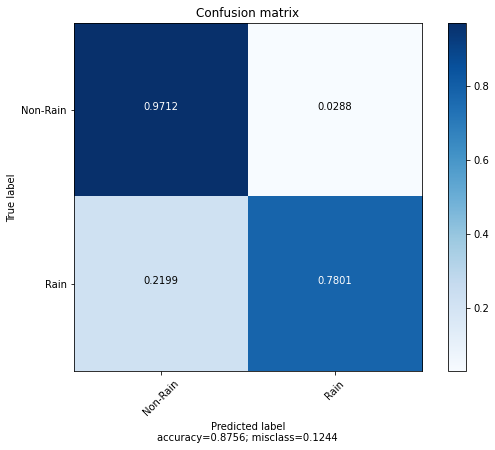

('Accuracy', 0.9378440660606836)
('Balanced Accuracy', 0.8756427891396894)
('f1', 0.8142337861105797)
('f1-weighted', 0.9367560561399175)
('AUC', 0.8756427891396894)
('averagePrecision', 0.7026589986192765)
('precision', 0.8515406162464986)
('recall', 0.7800586510263929)
('g_mean', 0.8734307616071993)


In [ ]:
cb_nan_RMSE, cb_nan_r2 = report_evaluation(y_pred_final_nan_cb, y_test, y_test_c)

REGRESSION: 

RMSE: 0.1634563822750525
R2: 0.7866284941897905

 CLASSIFICATION: 



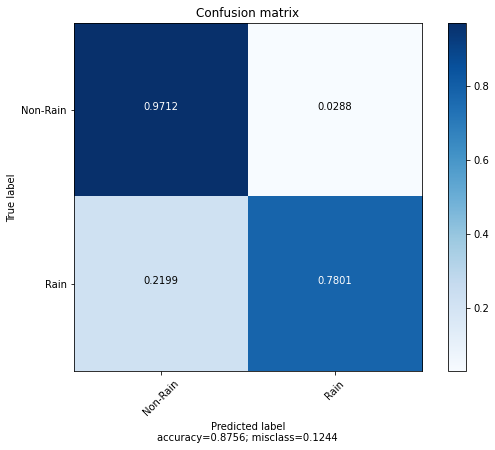

('Accuracy', 0.9378440660606836)
('Balanced Accuracy', 0.8756427891396894)
('f1', 0.8142337861105797)
('f1-weighted', 0.9367560561399175)
('AUC', 0.8756427891396894)
('averagePrecision', 0.7026589986192765)
('precision', 0.8515406162464986)
('recall', 0.7800586510263929)
('g_mean', 0.8734307616071993)


In [ ]:
xgb_nan_RMSE, xgb_nan_r2 = report_evaluation(y_pred_final_nan_xgboost, y_test, y_test_c)

REGRESSION: 

RMSE: 0.16216897385357346
R2: 0.7899763536485822

 CLASSIFICATION: 



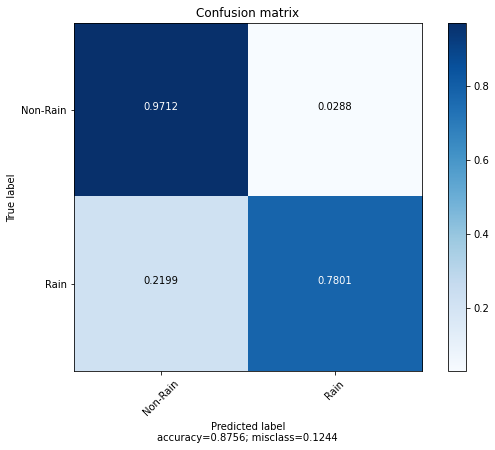

('Accuracy', 0.9378440660606836)
('Balanced Accuracy', 0.8756427891396894)
('f1', 0.8142337861105797)
('f1-weighted', 0.9367560561399175)
('AUC', 0.8756427891396894)
('averagePrecision', 0.7026589986192765)
('precision', 0.8515406162464986)
('recall', 0.7800586510263929)
('g_mean', 0.8734307616071993)


In [ ]:
lgbm_nan_RMSE, lgbm_nan_r2 = report_evaluation(y_pred_final_nan_lgbm, y_test, y_test_c)

REGRESSION: 

RMSE: 0.16285703185110348
R2: 0.7881903768410984

 CLASSIFICATION: 



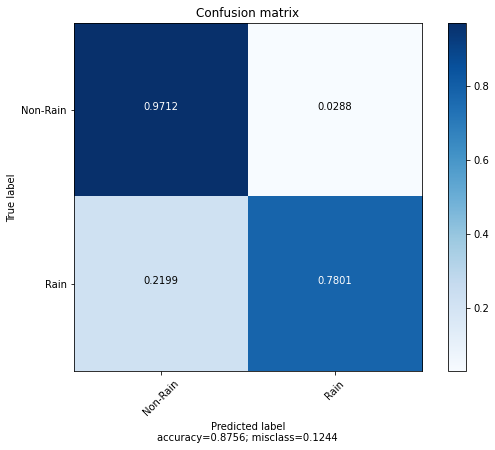

('Accuracy', 0.9378440660606836)
('Balanced Accuracy', 0.8756427891396894)
('f1', 0.8142337861105797)
('f1-weighted', 0.9367560561399175)
('AUC', 0.8756427891396894)
('averagePrecision', 0.7026589986192765)
('precision', 0.8515406162464986)
('recall', 0.7800586510263929)
('g_mean', 0.8734307616071993)


In [ ]:
cb_RMSE, cb_r2 = report_evaluation(y_pred_final_cb, y_test, y_test_c)

REGRESSION: 

RMSE: 0.1660078090660541
R2: 0.7799153807274971

 CLASSIFICATION: 



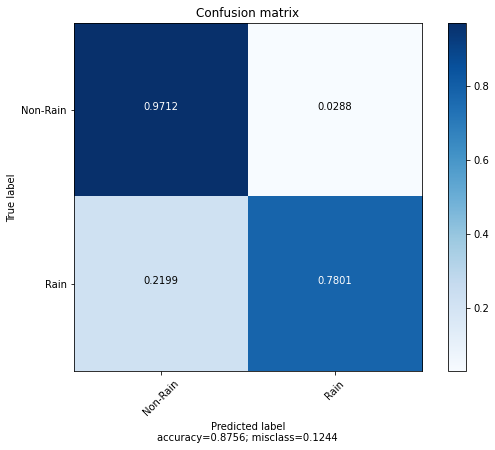

('Accuracy', 0.9378440660606836)
('Balanced Accuracy', 0.8756427891396894)
('f1', 0.8142337861105797)
('f1-weighted', 0.9367560561399175)
('AUC', 0.8756427891396894)
('averagePrecision', 0.7026589986192765)
('precision', 0.8515406162464986)
('recall', 0.7800586510263929)
('g_mean', 0.8734307616071993)


In [ ]:
xgb_RMSE, xgb_r2 = report_evaluation(y_pred_final_xgboost, y_test, y_test_c)

REGRESSION: 

RMSE: 0.16213690680796622
R2: 0.7900594049477037

 CLASSIFICATION: 



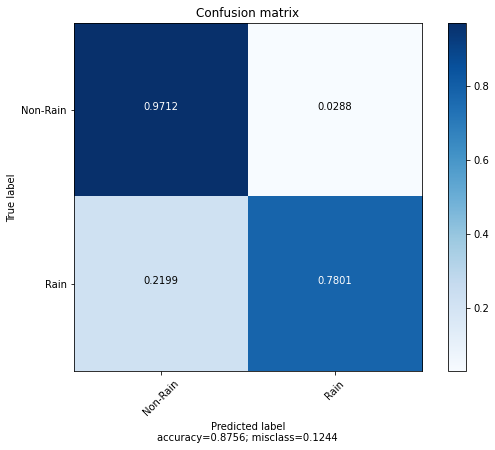

('Accuracy', 0.9378440660606836)
('Balanced Accuracy', 0.8756427891396894)
('f1', 0.8142337861105797)
('f1-weighted', 0.9367560561399175)
('AUC', 0.8756427891396894)
('averagePrecision', 0.7026589986192765)
('precision', 0.8515406162464986)
('recall', 0.7800586510263929)
('g_mean', 0.8734307616071993)


In [ ]:
lgbm_RMSE, lgbm_r2 = report_evaluation(y_pred_final_lgbm, y_test, y_test_c)

REGRESSION: 

RMSE: 0.17136331683635458
R2: 0.765486215011753

 CLASSIFICATION: 



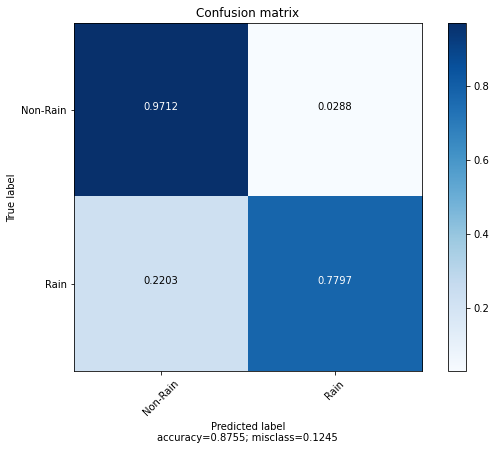

('Accuracy', 0.9377800537703239)
('Balanced Accuracy', 0.8754595046822113)
('f1', 0.8140068886337543)
('f1-weighted', 0.9366858948041692)
('AUC', 0.8754595046822115)
('averagePrecision', 0.7023645244769963)
('precision', 0.8514811849479583)
('recall', 0.7796920821114369)
('g_mean', 0.8732385089423044)


In [ ]:
svr_RMSE, svr_r2 = report_evaluation(y_pred_final_svr, y_test, y_test_c)

REGRESSION: 

RMSE: 0.1908379479652438
R2: 0.7091546444427012

 CLASSIFICATION: 



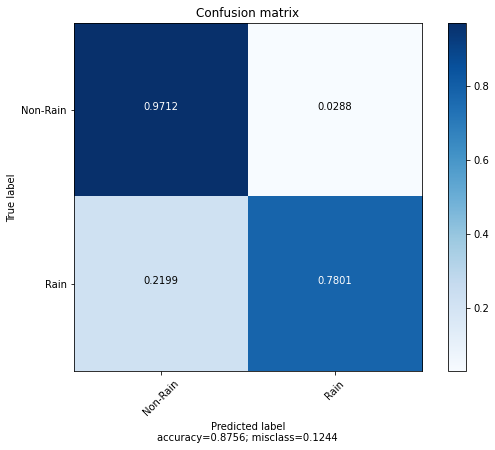

('Accuracy', 0.9378440660606836)
('Balanced Accuracy', 0.8756427891396894)
('f1', 0.8142337861105797)
('f1-weighted', 0.9367560561399175)
('AUC', 0.8756427891396894)
('averagePrecision', 0.7026589986192765)
('precision', 0.8515406162464986)
('recall', 0.7800586510263929)
('g_mean', 0.8734307616071993)


In [ ]:
knr_RMSE, knr_r2 = report_evaluation(y_pred_final_knr, y_test, y_test_c)

REGRESSION: 

RMSE: 0.31623643678333085
R2: 0.2013500426891709

 CLASSIFICATION: 



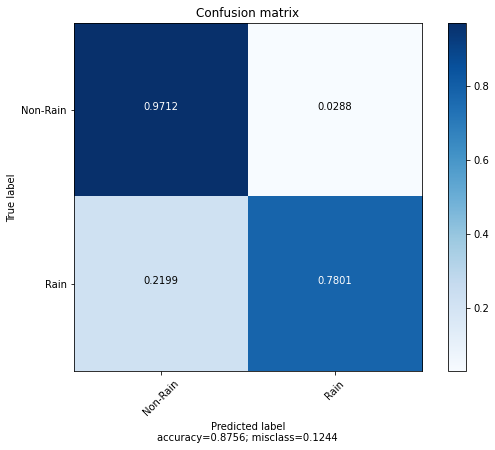

('Accuracy', 0.9378440660606836)
('Balanced Accuracy', 0.8756427891396894)
('f1', 0.8142337861105797)
('f1-weighted', 0.9367560561399175)
('AUC', 0.8756427891396894)
('averagePrecision', 0.7026589986192765)
('precision', 0.8515406162464986)
('recall', 0.7800586510263929)
('g_mean', 0.8734307616071993)


In [ ]:
ridge_RMSE, ridge_r2 = report_evaluation(y_pred_final_ridge, y_test, y_test_c)

REGRESSION: 

RMSE: 0.2536812838392627
R2: 0.4860634429463062

 CLASSIFICATION: 



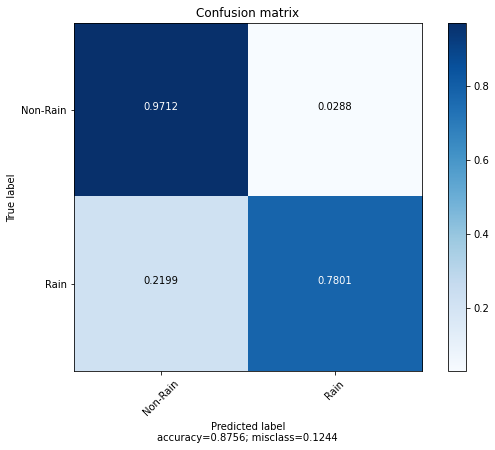

('Accuracy', 0.9378440660606836)
('Balanced Accuracy', 0.8756427891396894)
('f1', 0.8142337861105797)
('f1-weighted', 0.9367560561399175)
('AUC', 0.8756427891396894)
('averagePrecision', 0.7026589986192765)
('precision', 0.8515406162464986)
('recall', 0.7800586510263929)
('g_mean', 0.8734307616071993)


In [ ]:
lasso_RMSE, lasso_r2 = report_evaluation(y_pred_final_lasso, y_test, y_test_c)

REGRESSION: 

RMSE: 0.2411020171361808
R2: 0.5357687791495498

 CLASSIFICATION: 



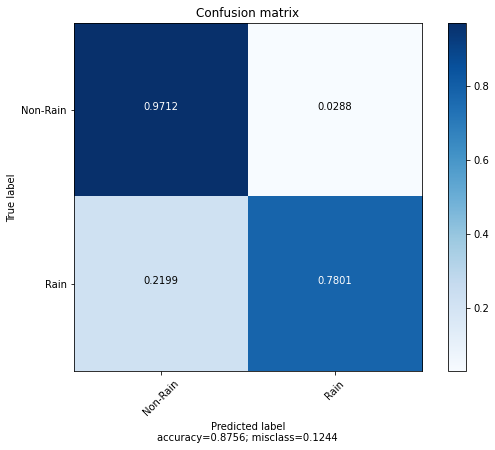

('Accuracy', 0.9378440660606836)
('Balanced Accuracy', 0.8756427891396894)
('f1', 0.8142337861105797)
('f1-weighted', 0.9367560561399175)
('AUC', 0.8756427891396894)
('averagePrecision', 0.7026589986192765)
('precision', 0.8515406162464986)
('recall', 0.7800586510263929)
('g_mean', 0.8734307616071993)


In [ ]:
elastic_RMSE, elastic_r2 = report_evaluation(y_pred_final_elastic, y_test, y_test_c)

REGRESSION: 

RMSE: 0.16588390832076483
R2: 0.7802437806077553

 CLASSIFICATION: 



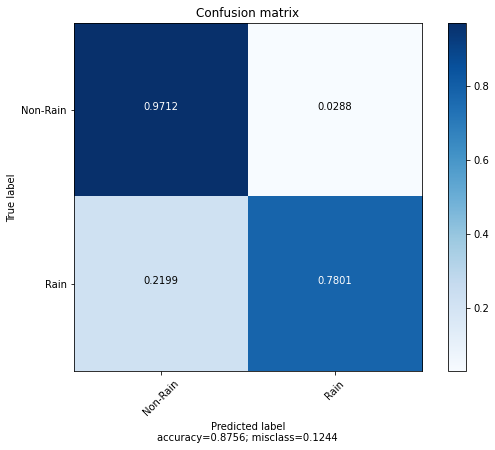

('Accuracy', 0.9378440660606836)
('Balanced Accuracy', 0.8756427891396894)
('f1', 0.8142337861105797)
('f1-weighted', 0.9367560561399175)
('AUC', 0.8756427891396894)
('averagePrecision', 0.7026589986192765)
('precision', 0.8515406162464986)
('recall', 0.7800586510263929)
('g_mean', 0.8734307616071993)


In [ ]:
stack_RMSE, stack_r2 = report_evaluation(y_pred_final_stack, y_test, y_test_c)

REGRESSION: 

RMSE: 0.16133876428598448
R2: 0.792121243844913

 CLASSIFICATION: 



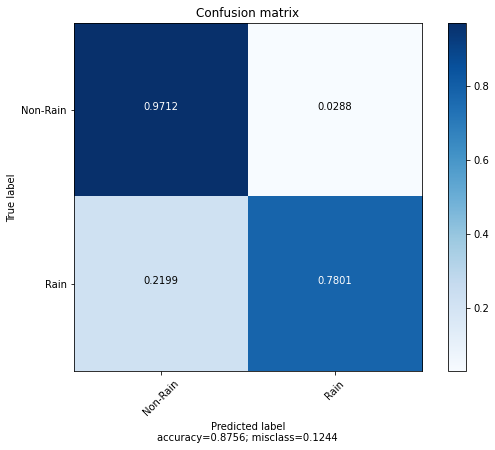

('Accuracy', 0.9378440660606836)
('Balanced Accuracy', 0.8756427891396894)
('f1', 0.8142337861105797)
('f1-weighted', 0.9367560561399175)
('AUC', 0.8756427891396894)
('averagePrecision', 0.7026589986192765)
('precision', 0.8515406162464986)
('recall', 0.7800586510263929)
('g_mean', 0.8734307616071993)


In [ ]:
blended_RMSE, blended_r2 = report_evaluation(blendedResults, y_test, y_test_c)

In [ ]:
allRMSE = [ridge_RMSE, lasso_RMSE, elastic_RMSE, knr_RMSE, svr_RMSE,xgb_nan_RMSE, xgb_RMSE, cb_nan_RMSE, cb_RMSE, lgbm_nan_RMSE, lgbm_RMSE, stack_RMSE, blended_RMSE]
allR2 = [ridge_r2, lasso_r2, elastic_r2, knr_r2, svr_r2,xgb_nan_r2, xgb_r2, cb_nan_r2, cb_r2, lgbm_nan_r2, lgbm_r2, stack_r2, blended_r2]
allAlgorithms = ["ridge", "lasso", "elasticnet", "KNN", "SVM Regressor", "XGB_Missing", "XGB", "CB_Missing", "CB", "LGBM_Missing", "LGBM", "Stacked Regressor", "Blended Model"]

In [ ]:
scoresDF = pd.DataFrame(np.array(np.transpose([allAlgorithms, allRMSE, allR2])), columns =["Algorithms", "RMSE", "R^2"])

In [ ]:
scoresDF.head()

,Algorithms,RMSE,R^2
0,ridge,0.31623643678333085,0.2013500426891709
1,lasso,0.2536812838392627,0.4860634429463062
2,elasticnet,0.2411020171361808,0.5357687791495498
3,KNN,0.1908379479652438,0.7091546444427012
4,SVM Regressor,0.17136331683635458,0.765486215011753


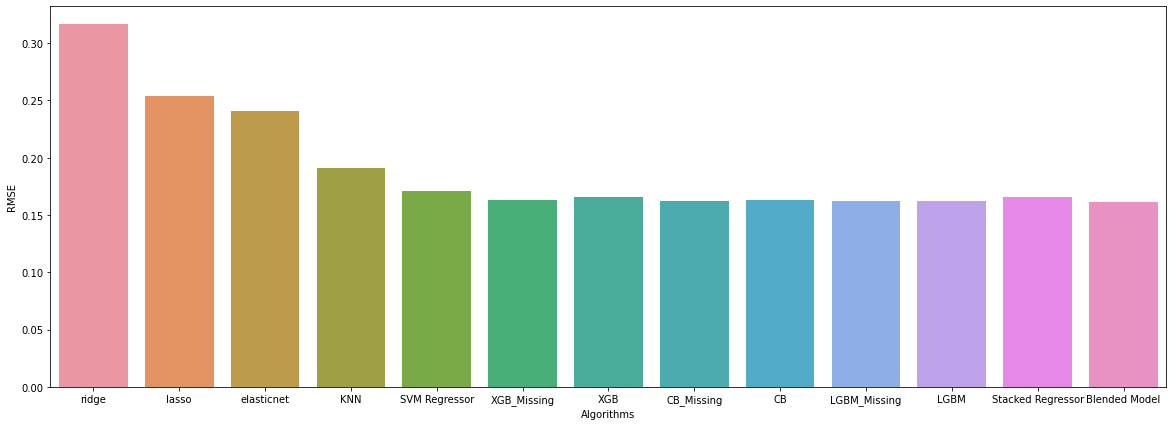

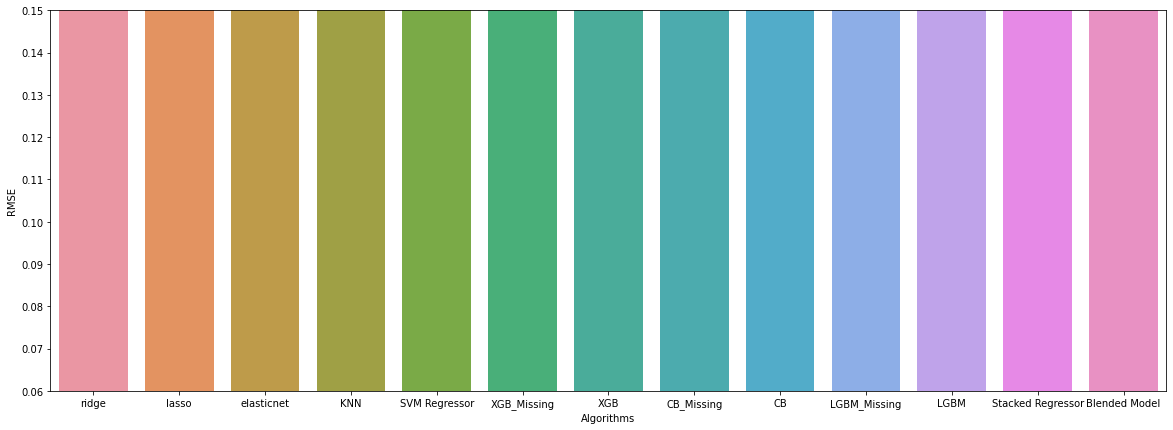

In [ ]:
f, ax1 = plt.subplots(figsize=(20,7))
sns.barplot(x = 'Algorithms', y='RMSE', data=scoresDF,)
f, ax1 = plt.subplots(figsize=(20,7))
ax1.set_ylim(0.06,0.15)
sns.barplot(x = 'Algorithms', y='RMSE', data=scoresDF,)

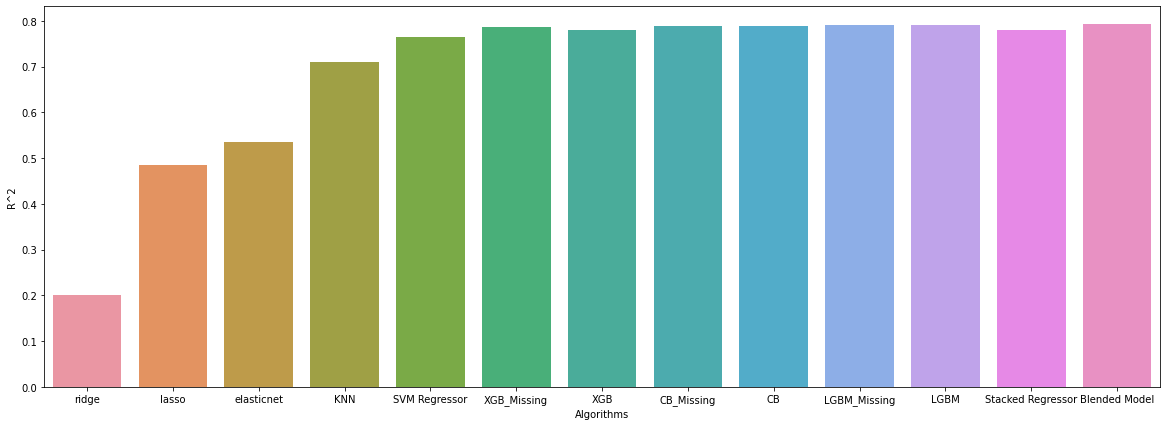

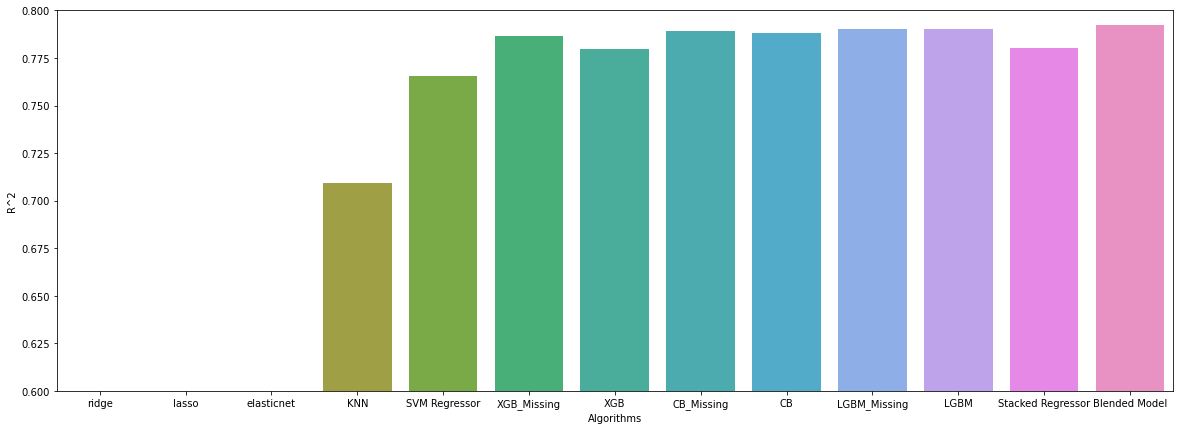

In [ ]:
f,ax = plt.subplots(figsize=(20,7))
sns.barplot(x = 'Algorithms', y='R^2', data=scoresDF)
f,ax = plt.subplots(figsize=(20,7))
ax.set_ylim(0.60,0.80)
sns.barplot(x = 'Algorithms', y='R^2', data=scoresDF)